In [21]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [22]:
tf.random.set_seed(1234)

In [23]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 128
SAMPLE_SIZE= 50000
BINS = 25

np_bg_SB = np.load('../data/processed/np_bg_SB_1.npy')
np_bg_SB= np_bg_SB[:,[0,1,2,3,4,5,6,7,8,11]]
test_data = np.load('../data/test_data_1.npy')
train_sig = np.load('../data/train_signal_1.npy')
train_background = np.load('../data/train_background_1.npy')
np_combined_SR_labeled = np.concatenate((train_sig, train_background), axis = 0)
gc.collect()

7552

In [24]:
sb = pd.DataFrame(np_bg_SB,columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj'])
sb

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj
0,1260.051636,0.422217,389.532013,622.454224,-1.856698,2.962399,22.999201,0.519086,0.787733,3107.620605
1,1255.513428,1.118943,55.797798,1244.178467,-0.326108,3.081639,359.113007,0.277957,0.590729,3233.075195
2,1567.896484,-0.666511,47.442600,1362.592896,-0.015116,3.094602,286.755005,0.488864,0.447114,3111.458496
3,1260.839600,-0.803750,478.921997,1129.338989,0.734482,3.122360,35.523300,0.429055,0.789323,3195.022705
4,1527.768188,0.584197,311.196991,1355.966553,1.416072,2.941976,114.981003,0.518980,0.821918,3162.099609
...,...,...,...,...,...,...,...,...,...,...
260141,1662.803223,-0.038826,84.837196,1444.321777,0.299155,3.184224,191.481003,0.434714,0.182728,3157.497070
260142,1584.508911,-0.455755,276.209991,1526.918213,-0.307391,3.100913,120.094002,0.437816,0.843754,3146.891602
260143,1500.259399,0.886107,146.237000,1213.367798,-0.822252,3.133430,225.348999,0.590159,0.572788,3764.679199
260144,1221.397339,1.198329,74.893898,1131.393311,-0.893655,3.104052,322.371002,0.677300,0.215650,3792.294189


In [8]:
train_sig.shape

(75502, 11)

In [9]:
np_combined_SR_labeled.shape

(196636, 11)

In [10]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR_labeled, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()




In [11]:

np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [13]:
gen_model = tf.keras.models.load_model('../Results/cdijetgan/1sb-notau32/models-1sb-notau32/epoch500-generator.h5')

In [14]:
sig_SR = sample_data(train_sig,1000)
bg_SR = sample_data(train_background,1000)
sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #put label 1 for real

generated_data = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
generated_data2 = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)

sampleB= sample_data(generated_data_labeled,2000) # generated data
sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1)

In [15]:
var = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb']
def plot_gen(a,b,j):
    fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 50))
    for i in range(0,10):
        
        axes[i].hist(a[:,i],25,alpha=0.6,histtype = 'step',label = 'data',density = True)

        #plt.hist(np_sig_SB[:,i],25,alpha = 0.6,histtype = 'step',label = 'signal',density = True)
        axes[i].hist(b[:,i],25,alpha = 0.6,histtype = 'step',label = 'generated',density = True)
        axes[i].set_title(var[i])

    plt.legend()
    plt.savefig('../Results/Classifier/PlotsSB2/plots_'+j)
    plt.close(fig)  


In [16]:
sig_SR = sample_data(train_sig,10)
bg_SR = sample_data(train_background,10)
sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #adding real fake label to real dat


In [17]:
gdf = pd.DataFrame(sampleA, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb','rf'])
gdf

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb,rf
0,1663.787354,0.413463,121.069000,1558.228394,-0.230827,3.140921,484.071014,0.684631,0.158839,3464.925781,1.0,1.0
1,1201.732788,-1.105329,129.669006,1076.807983,0.958587,3.149501,483.681000,0.397500,0.479134,3673.697510,1.0,1.0
2,1680.264648,0.429438,95.560303,1571.453979,-0.341391,3.129062,525.158020,0.409124,0.289107,3577.777832,1.0,1.0
3,1626.908813,-0.504713,125.987999,1427.677368,0.566023,3.136576,457.416992,0.165454,0.491897,3561.620361,1.0,1.0
4,1414.512817,-1.144184,151.966003,1315.829468,0.202791,3.133566,481.455994,0.353929,0.164375,3470.175293,1.0,1.0
5,1721.505981,-0.121319,113.523003,1695.055908,0.089013,3.154124,506.259003,0.442258,0.628457,3512.736328,1.0,1.0
6,1722.033203,-0.280373,475.391998,1615.671265,0.103275,3.140959,264.933014,0.289076,0.483287,3481.490479,1.0,1.0
7,1712.097046,0.464553,531.823975,1650.334839,-0.004374,3.140761,95.062202,0.123565,0.667812,3532.506348,1.0,1.0
8,1772.366089,-0.384310,196.194000,1689.727173,-0.634367,3.174778,439.122986,0.782900,0.423814,3551.832031,1.0,1.0
9,1747.773926,-0.077076,96.151100,1739.200806,0.243000,3.152123,487.395996,0.568617,0.427127,3599.670654,1.0,1.0


In [23]:
def train_generated(s,b,iteration,ratio):
    
    fpr_list = []
    tpr_list = []
    auc_list = []
    
    #generate fake background data and add signal background labels
    generated_data = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
    generated_data2 = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
    generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
    generated_data_labeled  = np.copy(generated_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1) 
    
    
    # sample a certain s/b ratio in SR from data and add real fake label
    sig_SR = sample_data(train_sig,s)
    bg_SR = sample_data(train_background,b)
    sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
    sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #adding real fake label to real data


    # sample s+b fake background and add real fake label
    sampleB= sample_data(generated_data_labeled,s+b) # generated data
    sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1) #adding real fake label to fake background
    
    #plot_gen(sampleA,sampleB,"Mixed_vs_Generated"+str(iteration))
    #plot_gen(sig_SR,sampleB,"sig_vs_fake"+str(iteration))
    #plot_gen(bg_SR,sampleB,"bg_vs_fake" + str(iteration))
    
    dataset = np.concatenate((sampleA,sampleB),axis=0) #dataset to traintest split
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) #rf label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label
    
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=50, batch_size=256,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    auc_list.append(auc_value)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')
    print(auc_value)
    print(auc_list)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    np.save('../Results/Classifier/generated/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_list),allow_pickle = True)
    np.save('../Results/Classifier/generated/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_list),allow_pickle = True)
    np.save('../Results/Classifier/generated/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_list),allow_pickle = True)
    

In [18]:
sb_ratio = [0.001 , 0.00215443, 0.00464159,0.01, 0.02154435, 0.04641589, 0.1 , 0.21544347  ,0.46415888 , 1.]

In [ ]:
for i in sb_ratio:
    if(i == 1.0):
        signal = 50000
        bg = 50000
    else:
        signal = (np.round(i * 100000))
        bg = (np.round((1 - i) * 100000))
    for j in range(5):
        train_generated(signal.astype(int),bg.astype(int),j,i)
        

In [25]:

def train_sb(s,b,iteration,ratio):
        
    fpr_sb = []
    tpr_sb = []
    auc_sb = []

    # sample a certain s/b ratio in SR from data and add real fake label
    sig_SR = sample_data(train_sig,s)
    bg_SR = sample_data(train_background,b)
    bg_SR2 =sample_data(train_background,s+b)

    
    dataset = np.concatenate((sig_SR ,bg_SR),axis=0) #dataset to traintest split
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) 
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label
    
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=25, batch_size=128,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    fpr_sb.append(fpr)
    tpr_sb.append(tpr)
    auc_sb.append(auc_value)
    np.save('../Results/Classifier/sbvsb/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_sb),allow_pickle = True)
    np.save('../Results/Classifier/sbvsb/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_sb),allow_pickle = True)
    np.save('../Results/Classifier/sbvsb/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_sb),allow_pickle = True)
    

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 62us/sample - loss: 0.0458 - tp: 0.0000e+00 - fp: 69.0000 - tn: 79850.0000 - fn: 81.0000 - accuracy: 0.9981 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4763 - val_loss: 0.0138 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4467
Epoch 2/25
80000/80000 [==============================] - 3s 39us/sample - loss: 0.0196 - tp: 0.0000e+00 - fp: 6.0000 - tn: 79913.0000 - fn: 81.0000 - accuracy: 0.9989 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4553 - val_loss: 0.0163 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5585
Epoch 3/25
80000/80000 [==============================] - 3s 39us/sample - loss: 0.0152 - tp: 0.0000e+00 - 

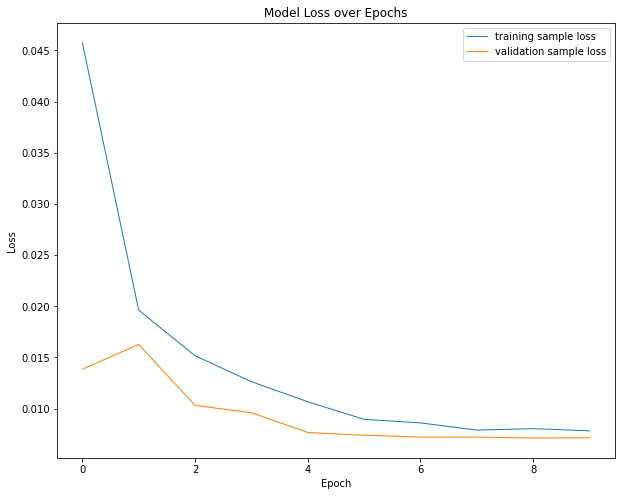

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 61us/sample - loss: 0.1028 - tp: 0.0000e+00 - fp: 382.0000 - tn: 79537.0000 - fn: 81.0000 - accuracy: 0.9942 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4786 - val_loss: 0.0156 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4570
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0227 - tp: 0.0000e+00 - fp: 17.0000 - tn: 79902.0000 - fn: 81.0000 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4587 - val_loss: 0.0168 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3568
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0212 - tp: 0.0000e+00 

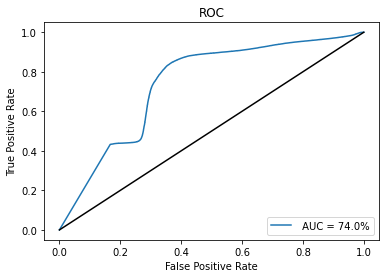

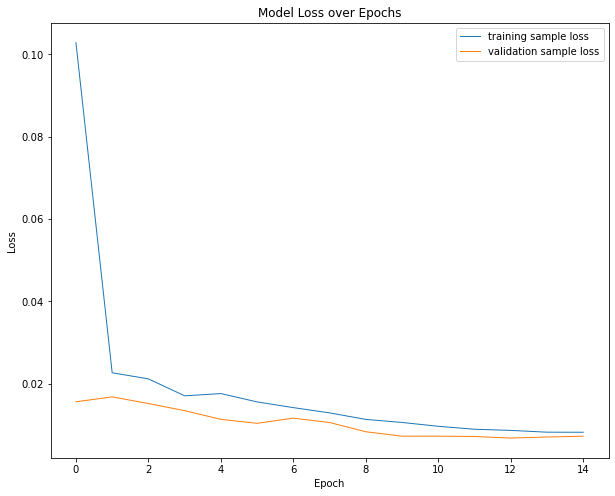

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.0341 - tp: 0.0000e+00 - fp: 22.0000 - tn: 79897.0000 - fn: 81.0000 - accuracy: 0.9987 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4613 - val_loss: 0.0155 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4616
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0187 - tp: 0.0000e+00 - fp: 4.0000 - tn: 79915.0000 - fn: 81.0000 - accuracy: 0.9989 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4479 - val_loss: 0.0144 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3149
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0151 - tp: 0.0000e+00 - 

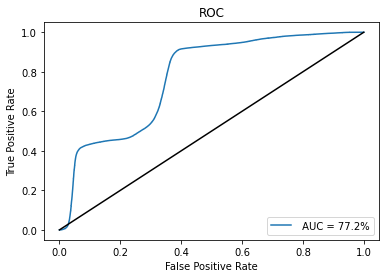

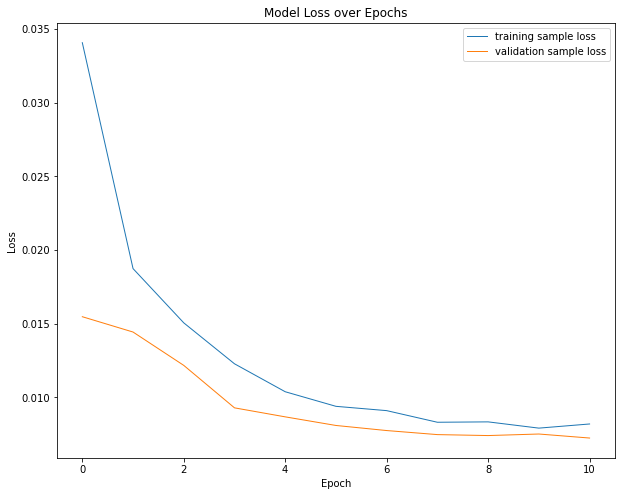

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 62us/sample - loss: 0.0539 - tp: 0.0000e+00 - fp: 201.0000 - tn: 79718.0000 - fn: 81.0000 - accuracy: 0.9965 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4787 - val_loss: 0.0175 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4466
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0196 - tp: 0.0000e+00 - fp: 4.0000 - tn: 79915.0000 - fn: 81.0000 - accuracy: 0.9989 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4601 - val_loss: 0.0176 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3686
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0154 - tp: 0.0000e+00 -

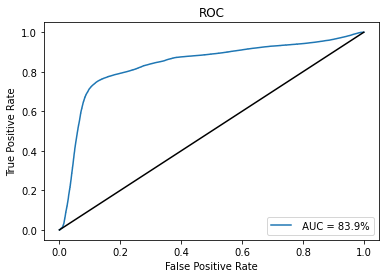

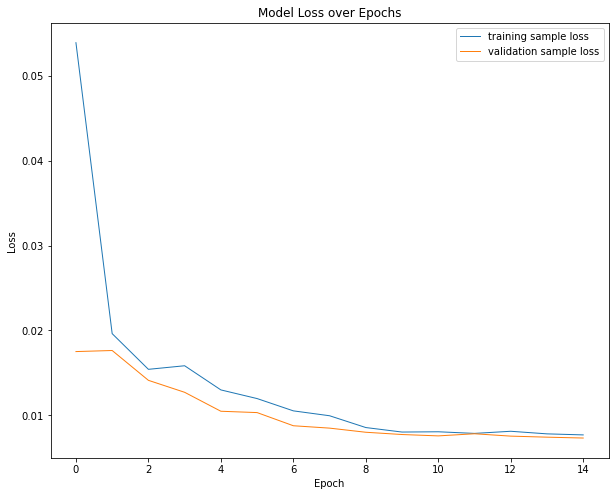

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.1330 - tp: 0.0000e+00 - fp: 522.0000 - tn: 79397.0000 - fn: 81.0000 - accuracy: 0.9925 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4780 - val_loss: 0.0174 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4428
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0220 - tp: 0.0000e+00 - fp: 15.0000 - tn: 79904.0000 - fn: 81.0000 - accuracy: 0.9988 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4555 - val_loss: 0.0149 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19981.0000 - val_fn: 19.0000 - val_accuracy: 0.9991 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3812
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0180 - tp: 0.0000e+00 

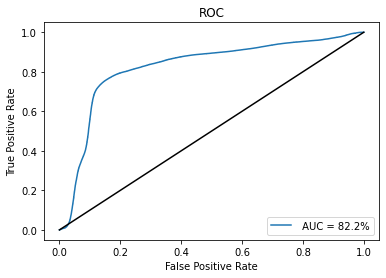

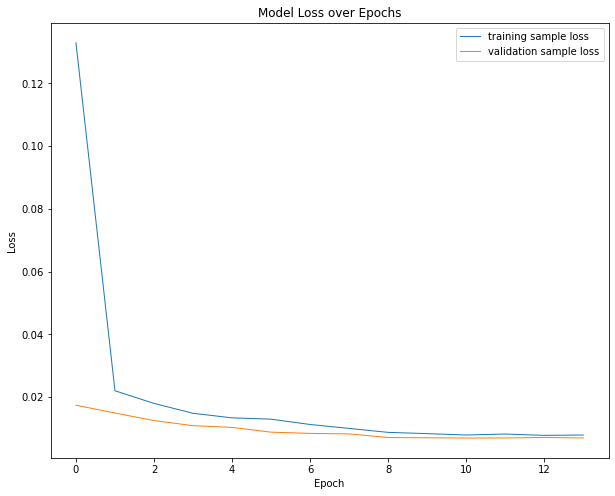

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 61us/sample - loss: 0.0727 - tp: 0.0000e+00 - fp: 111.0000 - tn: 79726.0000 - fn: 163.0000 - accuracy: 0.9966 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4739 - val_loss: 0.0287 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4245
Epoch 2/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0280 - tp: 0.0000e+00 - fp: 13.0000 - tn: 79824.0000 - fn: 163.0000 - accuracy: 0.9978 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4436 - val_loss: 0.0269 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4884
Epoch 3/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0225 - tp: 0.0000e+0

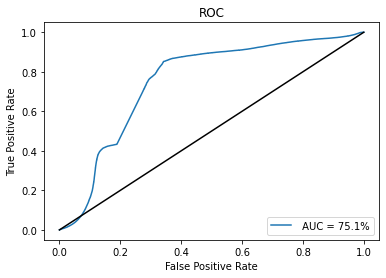

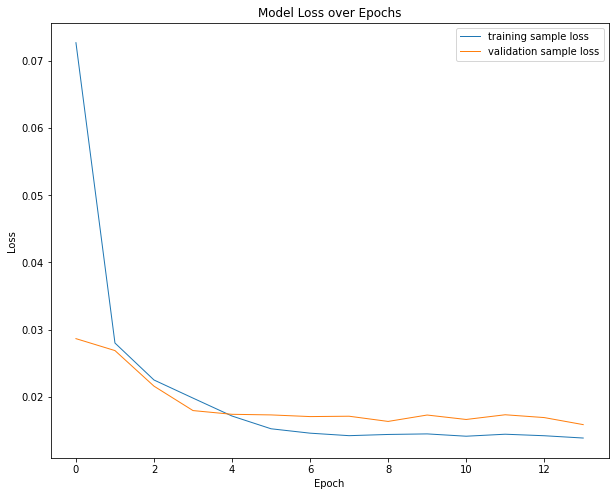

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.0683 - tp: 1.0000 - fp: 171.0000 - tn: 79666.0000 - fn: 162.0000 - accuracy: 0.9958 - precision: 0.0058 - recall: 0.0061 - auc: 0.4520 - val_loss: 0.0337 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4074
Epoch 2/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0299 - tp: 0.0000e+00 - fp: 9.0000 - tn: 79828.0000 - fn: 163.0000 - accuracy: 0.9979 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4408 - val_loss: 0.0306 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6859
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0239 - tp: 0.0000e+00 - fp: 4.000

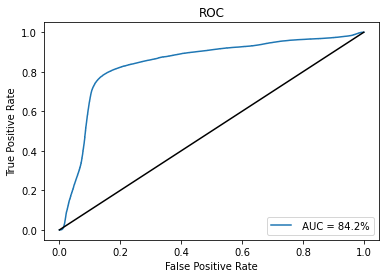

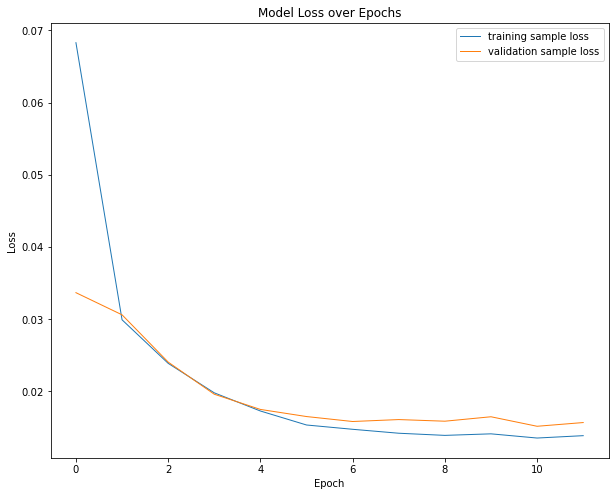

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 60us/sample - loss: 0.1251 - tp: 1.0000 - fp: 310.0000 - tn: 79527.0000 - fn: 162.0000 - accuracy: 0.9941 - precision: 0.0032 - recall: 0.0061 - auc: 0.4640 - val_loss: 0.0318 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4126
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0320 - tp: 0.0000e+00 - fp: 20.0000 - tn: 79817.0000 - fn: 163.0000 - accuracy: 0.9977 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4583 - val_loss: 0.0287 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5250
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0297 - tp: 0.0000e+00 - fp: 10.0

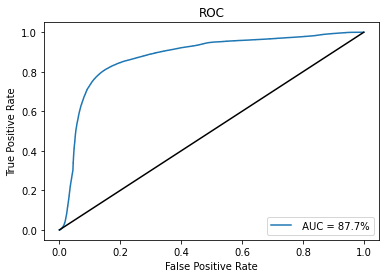

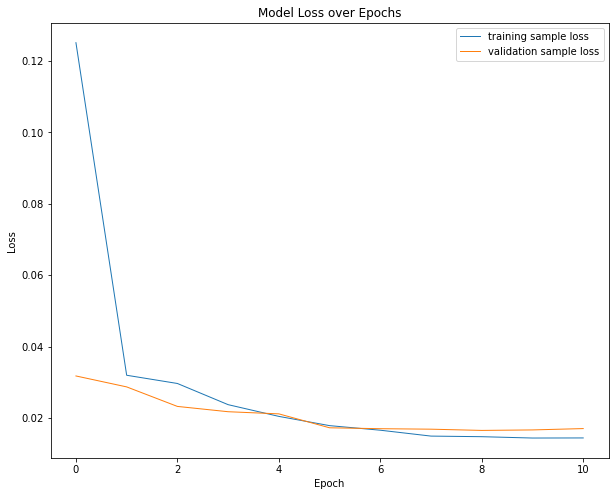

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.0971 - tp: 0.0000e+00 - fp: 237.0000 - tn: 79600.0000 - fn: 163.0000 - accuracy: 0.9950 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4704 - val_loss: 0.0398 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4545
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0364 - tp: 1.0000 - fp: 24.0000 - tn: 79813.0000 - fn: 162.0000 - accuracy: 0.9977 - precision: 0.0400 - recall: 0.0061 - auc: 0.4384 - val_loss: 0.0308 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3146
Epoch 3/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0274 - tp: 0.0000e+00 - fp: 6.00

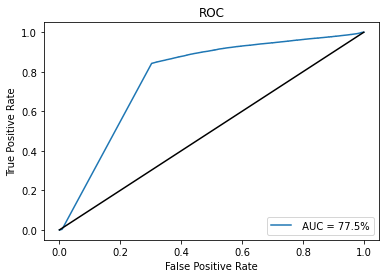

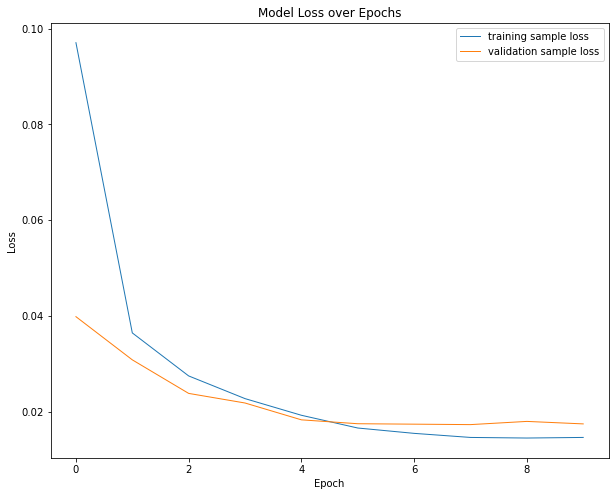

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.2352 - tp: 0.0000e+00 - fp: 460.0000 - tn: 79377.0000 - fn: 163.0000 - accuracy: 0.9922 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4678 - val_loss: 0.0321 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4142
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0363 - tp: 0.0000e+00 - fp: 27.0000 - tn: 79810.0000 - fn: 163.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4395 - val_loss: 0.0307 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19948.0000 - val_fn: 52.0000 - val_accuracy: 0.9974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5115
Epoch 3/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0311 - tp: 0.0000e+0

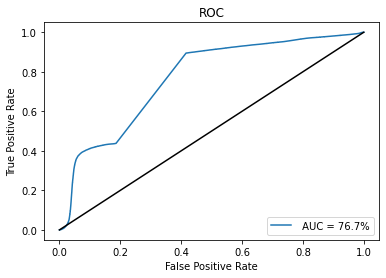

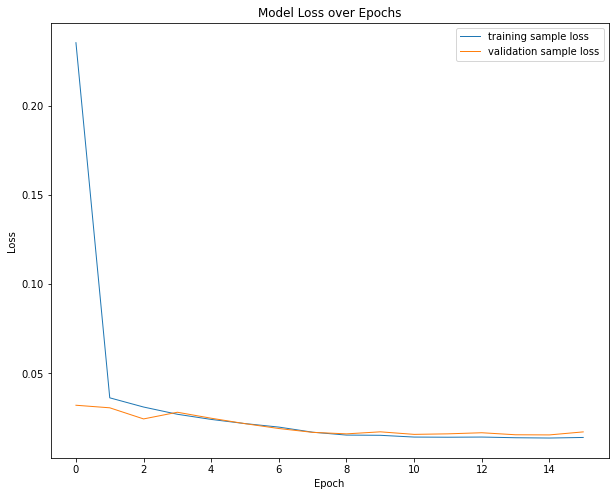

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 62us/sample - loss: 0.1485 - tp: 1.0000 - fp: 244.0000 - tn: 79388.0000 - fn: 367.0000 - accuracy: 0.9924 - precision: 0.0041 - recall: 0.0027 - auc: 0.4300 - val_loss: 0.0508 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3631
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0515 - tp: 0.0000e+00 - fp: 17.0000 - tn: 79615.0000 - fn: 368.0000 - accuracy: 0.9952 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4366 - val_loss: 0.0416 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5934
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0386 - tp: 0.0000e+00 - fp: 4.00

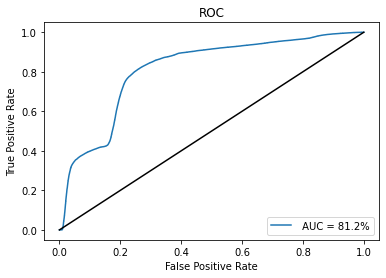

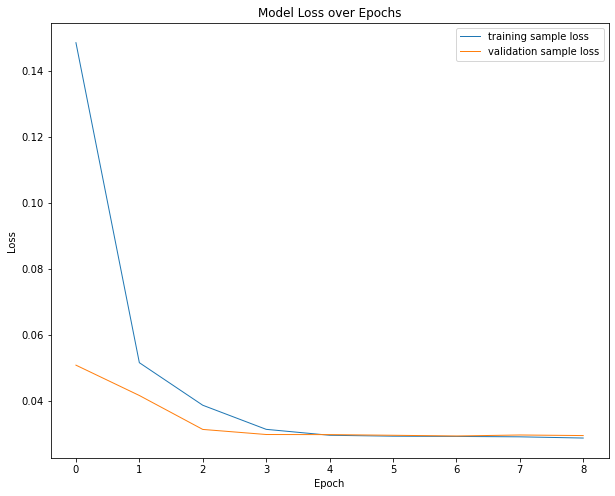

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.1165 - tp: 0.0000e+00 - fp: 257.0000 - tn: 79375.0000 - fn: 368.0000 - accuracy: 0.9922 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4281 - val_loss: 0.0476 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5459
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0512 - tp: 0.0000e+00 - fp: 13.0000 - tn: 79619.0000 - fn: 368.0000 - accuracy: 0.9952 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4275 - val_loss: 0.0401 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4900
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0415 - tp: 0.0000e+0

80000/80000 [==============================] - 3s 36us/sample - loss: 0.0259 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79632.0000 - fn: 368.0000 - accuracy: 0.9954 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8140 - val_loss: 0.0244 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8930
Epoch 00020: early stopping


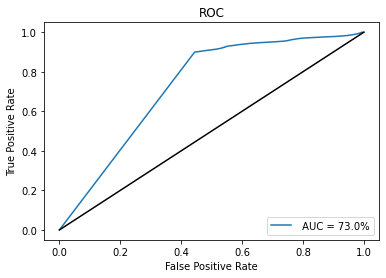

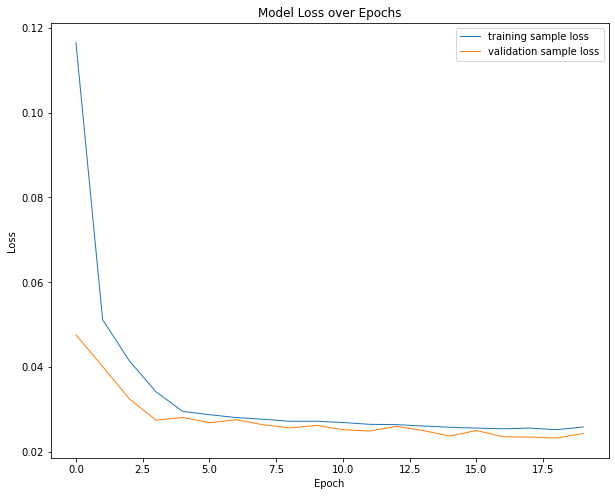

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 63us/sample - loss: 0.0885 - tp: 0.0000e+00 - fp: 183.0000 - tn: 79449.0000 - fn: 368.0000 - accuracy: 0.9931 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4457 - val_loss: 0.0478 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5098
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0461 - tp: 0.0000e+00 - fp: 11.0000 - tn: 79621.0000 - fn: 368.0000 - accuracy: 0.9953 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4912 - val_loss: 0.0386 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5664
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0378 - tp: 0.0000e+0

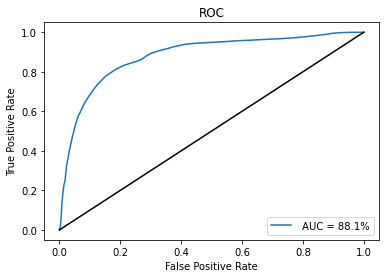

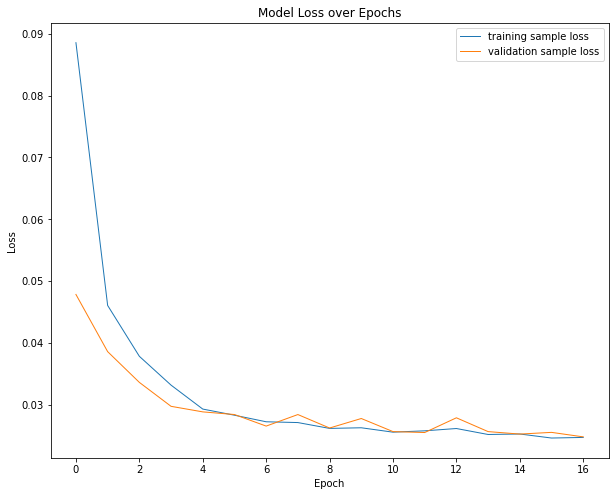

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 60us/sample - loss: 0.2483 - tp: 2.0000 - fp: 676.0000 - tn: 78956.0000 - fn: 366.0000 - accuracy: 0.9870 - precision: 0.0029 - recall: 0.0054 - auc: 0.4411 - val_loss: 0.0574 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4105
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0570 - tp: 0.0000e+00 - fp: 16.0000 - tn: 79616.0000 - fn: 368.0000 - accuracy: 0.9952 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4249 - val_loss: 0.0467 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6313
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0476 - tp: 0.0000e+00 - fp: 6.00

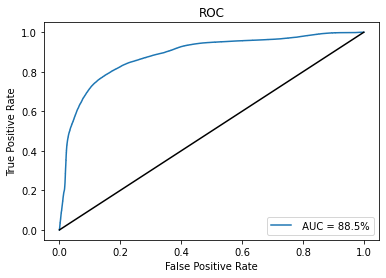

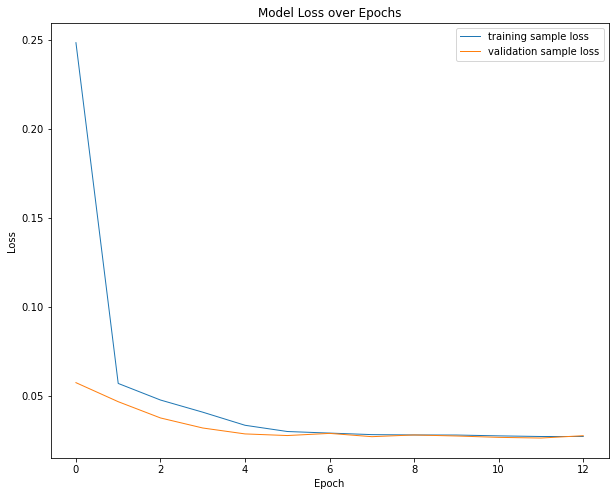

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.0796 - tp: 0.0000e+00 - fp: 158.0000 - tn: 79474.0000 - fn: 368.0000 - accuracy: 0.9934 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4395 - val_loss: 0.0521 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4921
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0466 - tp: 0.0000e+00 - fp: 8.0000 - tn: 79624.0000 - fn: 368.0000 - accuracy: 0.9953 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4547 - val_loss: 0.0360 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19904.0000 - val_fn: 96.0000 - val_accuracy: 0.9952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6104
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0371 - tp: 0.0000e+00

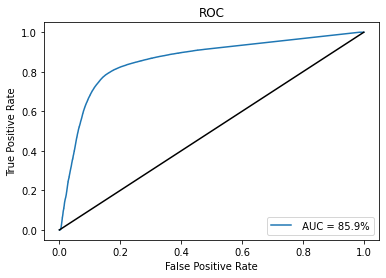

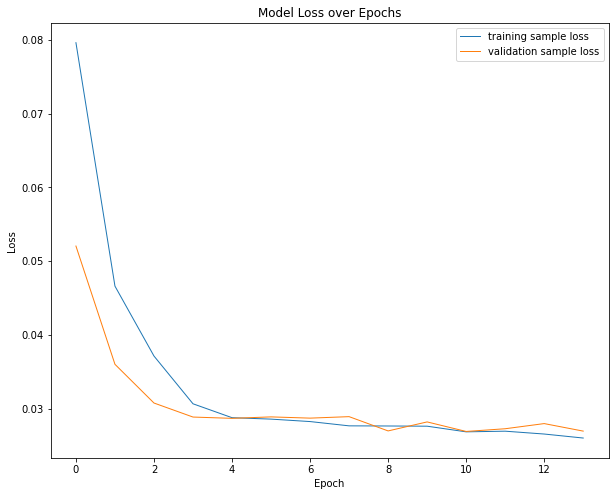

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.2039 - tp: 7.0000 - fp: 484.0000 - tn: 78707.0000 - fn: 802.0000 - accuracy: 0.9839 - precision: 0.0143 - recall: 0.0087 - auc: 0.4265 - val_loss: 0.0687 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6324
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0807 - tp: 0.0000e+00 - fp: 12.0000 - tn: 79179.0000 - fn: 809.0000 - accuracy: 0.9897 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4821 - val_loss: 0.0604 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6917
Epoch 3/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.0632 - tp: 0.0000e+00 - fp: 4.

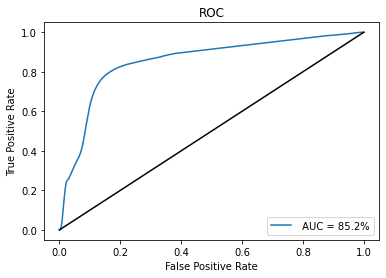

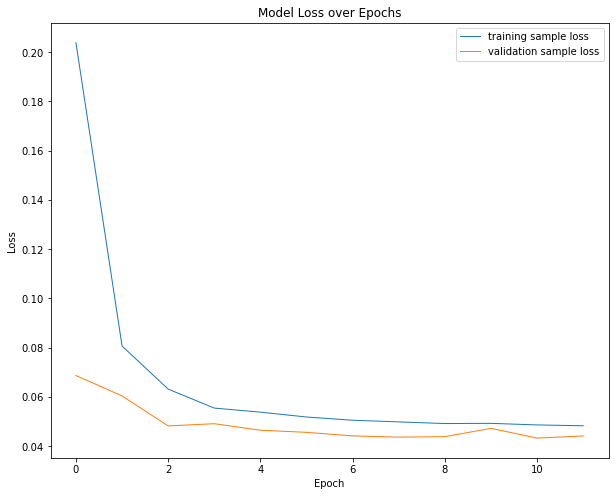

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.2216 - tp: 8.0000 - fp: 573.0000 - tn: 78618.0000 - fn: 801.0000 - accuracy: 0.9828 - precision: 0.0138 - recall: 0.0099 - auc: 0.4137 - val_loss: 0.0858 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5162
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0888 - tp: 4.0000 - fp: 26.0000 - tn: 79165.0000 - fn: 805.0000 - accuracy: 0.9896 - precision: 0.1333 - recall: 0.0049 - auc: 0.4601 - val_loss: 0.0665 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6775
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0711 - tp: 1.0000 - fp: 7.0000 - tn: 79184

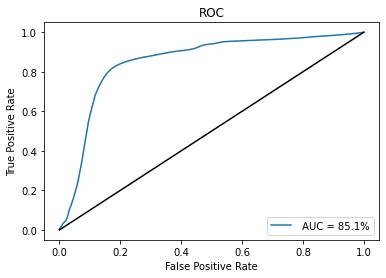

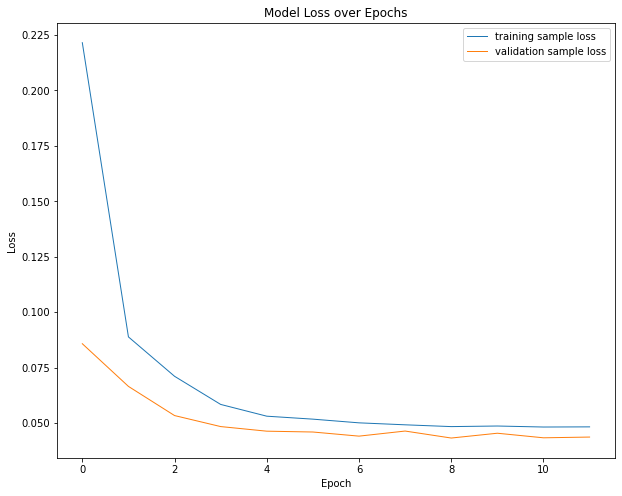

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 62us/sample - loss: 0.2140 - tp: 12.0000 - fp: 576.0000 - tn: 78615.0000 - fn: 797.0000 - accuracy: 0.9828 - precision: 0.0204 - recall: 0.0148 - auc: 0.4244 - val_loss: 0.0834 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5731
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0865 - tp: 0.0000e+00 - fp: 14.0000 - tn: 79177.0000 - fn: 809.0000 - accuracy: 0.9897 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4853 - val_loss: 0.0656 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6979
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0677 - tp: 1.0000 - fp: 7.000

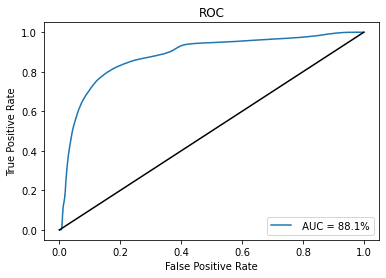

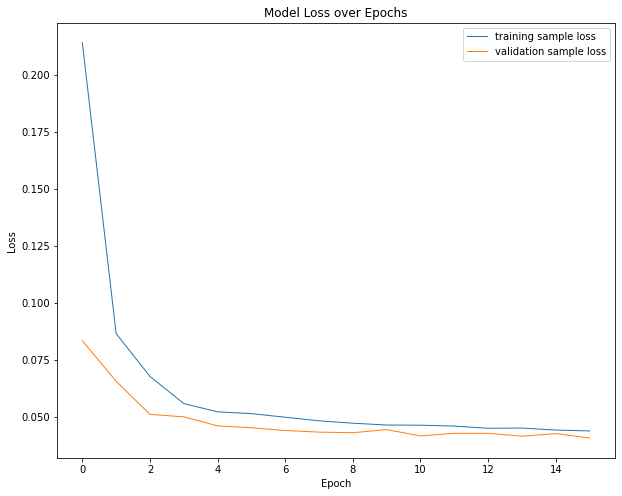

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.3820 - tp: 17.0000 - fp: 952.0000 - tn: 78239.0000 - fn: 792.0000 - accuracy: 0.9782 - precision: 0.0175 - recall: 0.0210 - auc: 0.4372 - val_loss: 0.0923 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4120
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0928 - tp: 2.0000 - fp: 62.0000 - tn: 79129.0000 - fn: 807.0000 - accuracy: 0.9891 - precision: 0.0312 - recall: 0.0025 - auc: 0.4592 - val_loss: 0.0725 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6635
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0764 - tp: 0.0000e+00 - fp: 13.0000 - tn:

80000/80000 [==============================] - 3s 36us/sample - loss: 0.0453 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79191.0000 - fn: 809.0000 - accuracy: 0.9899 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8534 - val_loss: 0.0393 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8964
Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0454 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79191.0000 - fn: 809.0000 - accuracy: 0.9899 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8570 - val_loss: 0.0433 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8604
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0456 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 79191.0000 - fn: 809.0000 -

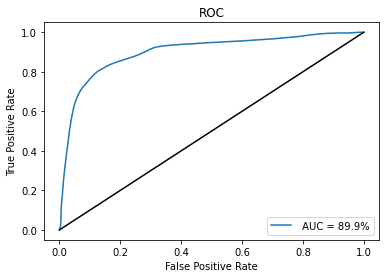

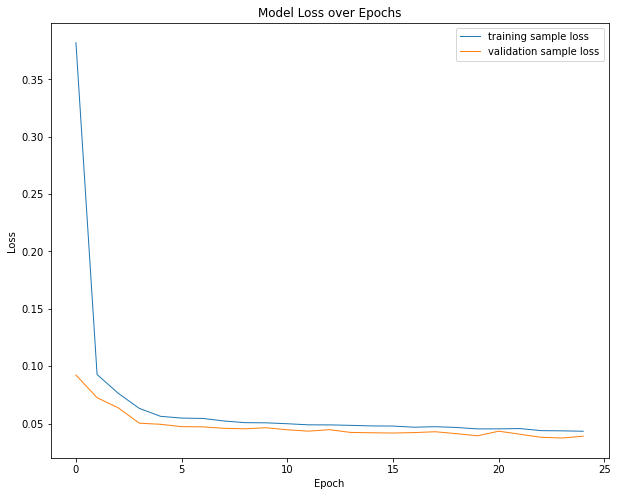

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.2403 - tp: 13.0000 - fp: 652.0000 - tn: 78539.0000 - fn: 796.0000 - accuracy: 0.9819 - precision: 0.0195 - recall: 0.0161 - auc: 0.4321 - val_loss: 0.0702 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6122
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0836 - tp: 1.0000 - fp: 21.0000 - tn: 79170.0000 - fn: 808.0000 - accuracy: 0.9896 - precision: 0.0455 - recall: 0.0012 - auc: 0.4739 - val_loss: 0.0630 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19809.0000 - val_fn: 191.0000 - val_accuracy: 0.9905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6254
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0627 - tp: 0.0000e+00 - fp: 4.0000 - tn: 

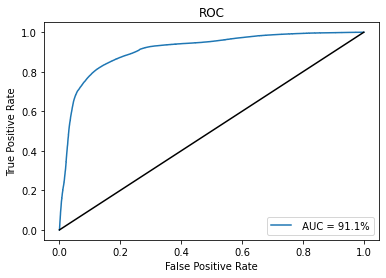

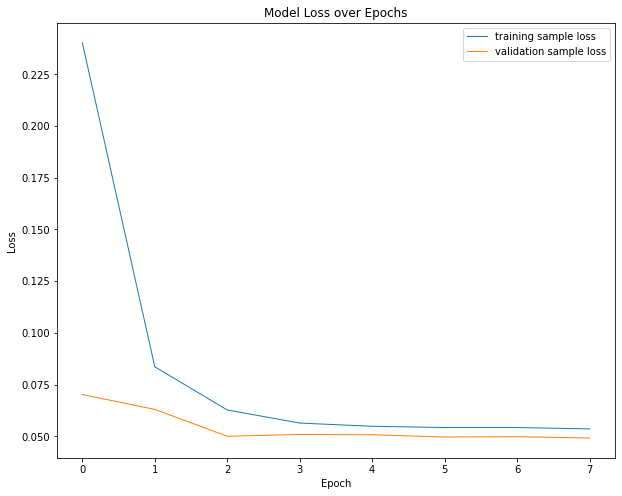

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 64us/sample - loss: 0.2091 - tp: 16.0000 - fp: 506.0000 - tn: 77781.0000 - fn: 1697.0000 - accuracy: 0.9725 - precision: 0.0307 - recall: 0.0093 - auc: 0.5032 - val_loss: 0.1192 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7120
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1133 - tp: 0.0000e+00 - fp: 19.0000 - tn: 78268.0000 - fn: 1713.0000 - accuracy: 0.9783 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6562 - val_loss: 0.0927 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8153
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0945 - tp: 0.0000e+00 - fp:

80000/80000 [==============================] - 3s 36us/sample - loss: 0.0728 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8915 - val_loss: 0.0717 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9033
Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0715 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8952 - val_loss: 0.0684 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9172
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0709 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.000

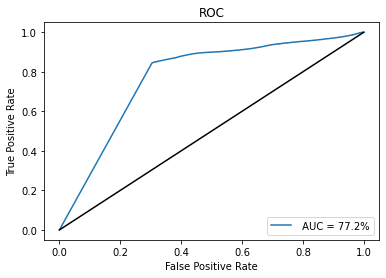

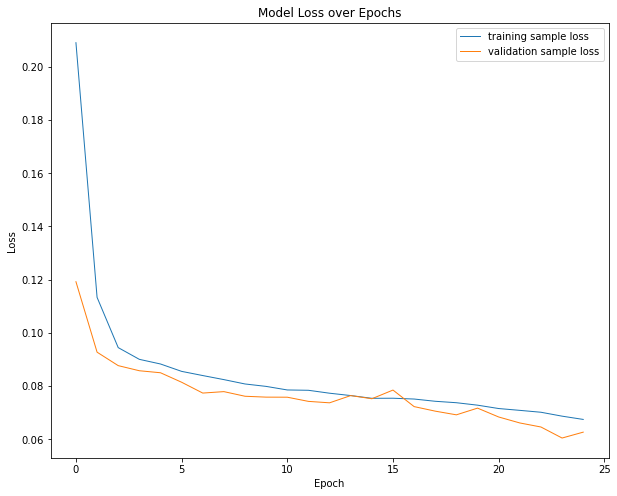

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.2023 - tp: 20.0000 - fp: 534.0000 - tn: 77753.0000 - fn: 1693.0000 - accuracy: 0.9722 - precision: 0.0361 - recall: 0.0117 - auc: 0.4872 - val_loss: 0.1176 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7090
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1137 - tp: 2.0000 - fp: 27.0000 - tn: 78260.0000 - fn: 1711.0000 - accuracy: 0.9783 - precision: 0.0690 - recall: 0.0012 - auc: 0.6447 - val_loss: 0.0995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7292
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0971 - tp: 3.0000 - fp: 19.0000 - tn: 7

80000/80000 [==============================] - 3s 35us/sample - loss: 0.0681 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9096 - val_loss: 0.0633 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9288
Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0679 - tp: 0.0000e+00 - fp: 1.0000 - tn: 78286.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9068 - val_loss: 0.0652 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9225
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0679 - tp: 0.0000e+00 - fp: 1.0000 - tn: 78286.0000 - fn: 1713.0000 - accu

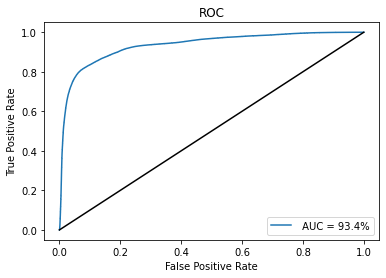

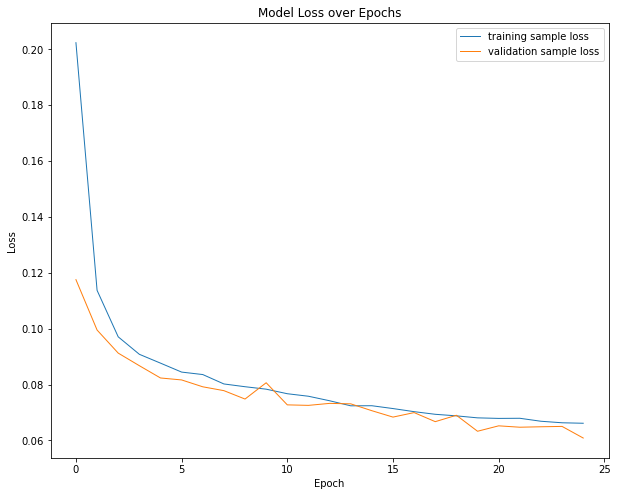

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.3188 - tp: 25.0000 - fp: 897.0000 - tn: 77390.0000 - fn: 1688.0000 - accuracy: 0.9677 - precision: 0.0271 - recall: 0.0146 - auc: 0.4502 - val_loss: 0.1213 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6664
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1224 - tp: 2.0000 - fp: 47.0000 - tn: 78240.0000 - fn: 1711.0000 - accuracy: 0.9780 - precision: 0.0408 - recall: 0.0012 - auc: 0.5938 - val_loss: 0.1004 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7832
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1010 - tp: 0.0000e+00 - fp: 9.0000 - tn

80000/80000 [==============================] - 3s 37us/sample - loss: 0.0718 - tp: 0.0000e+00 - fp: 3.0000 - tn: 78284.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8937 - val_loss: 0.0693 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9186
Epoch 21/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.0716 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8965 - val_loss: 0.0769 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8801
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0709 - tp: 0.0000e+00 - fp: 1.0000 - tn: 78286.0000 - fn: 1713.0000 - accu

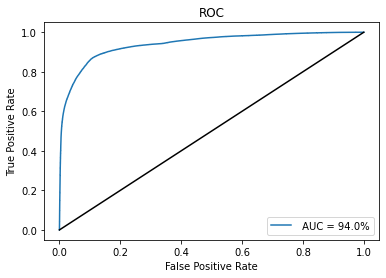

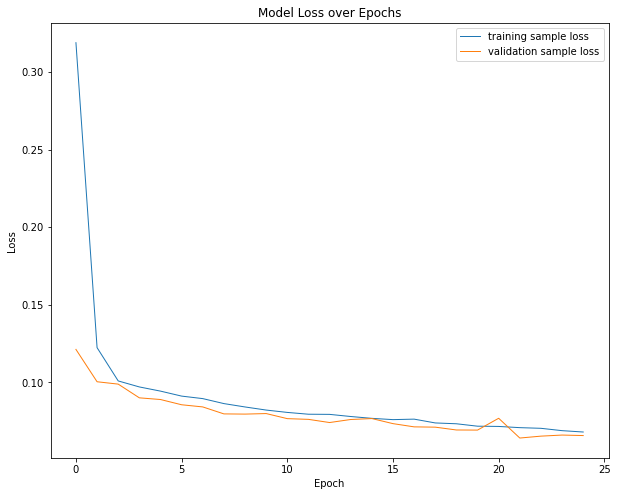

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.2656 - tp: 20.0000 - fp: 639.0000 - tn: 77648.0000 - fn: 1693.0000 - accuracy: 0.9708 - precision: 0.0303 - recall: 0.0117 - auc: 0.4416 - val_loss: 0.1257 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6696
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1218 - tp: 2.0000 - fp: 31.0000 - tn: 78256.0000 - fn: 1711.0000 - accuracy: 0.9782 - precision: 0.0606 - recall: 0.0012 - auc: 0.6043 - val_loss: 0.0993 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7681
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0999 - tp: 1.0000 - fp: 17.0000 - tn: 7

80000/80000 [==============================] - 3s 36us/sample - loss: 0.0695 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9054 - val_loss: 0.0661 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9221
Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.0685 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9077 - val_loss: 0.0659 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9201
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0684 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.000

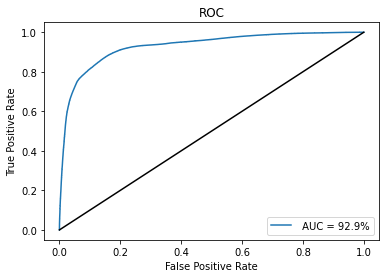

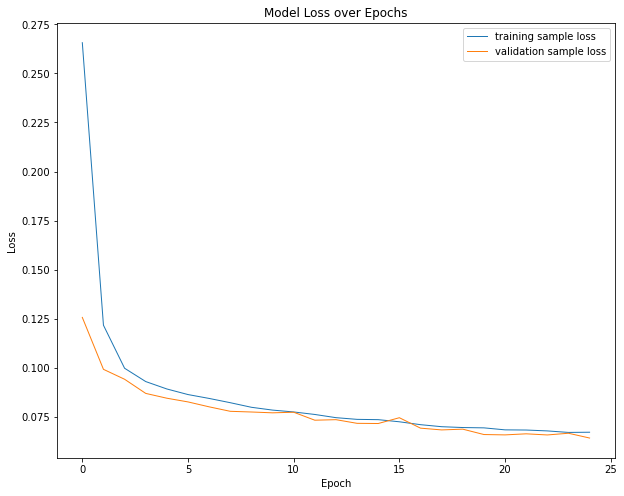

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.3249 - tp: 31.0000 - fp: 842.0000 - tn: 77445.0000 - fn: 1682.0000 - accuracy: 0.9685 - precision: 0.0355 - recall: 0.0181 - auc: 0.4533 - val_loss: 0.1280 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6267
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1303 - tp: 4.0000 - fp: 41.0000 - tn: 78246.0000 - fn: 1709.0000 - accuracy: 0.9781 - precision: 0.0889 - recall: 0.0023 - auc: 0.5805 - val_loss: 0.1029 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7690
Epoch 3/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.1065 - tp: 1.0000 - fp: 7.0000 - tn: 78

80000/80000 [==============================] - 3s 37us/sample - loss: 0.0675 - tp: 0.0000e+00 - fp: 2.0000 - tn: 78285.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9078 - val_loss: 0.0613 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9367
Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0674 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - accuracy: 0.9786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9102 - val_loss: 0.0634 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19559.0000 - val_fn: 441.0000 - val_accuracy: 0.9779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9404
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0664 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 78287.0000 - fn: 1713.0000 - 

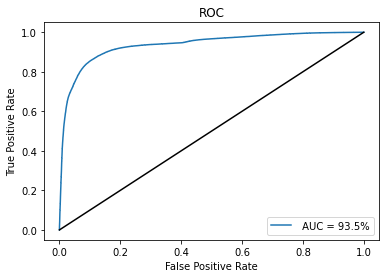

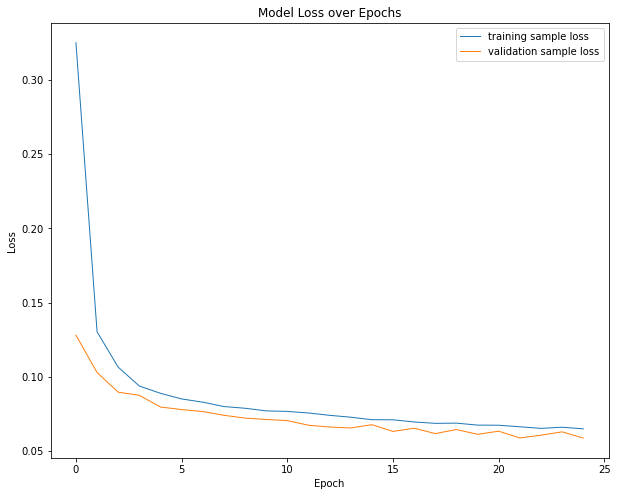

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.5378 - tp: 168.0000 - fp: 1826.0000 - tn: 74476.0000 - fn: 3530.0000 - accuracy: 0.9330 - precision: 0.0843 - recall: 0.0454 - auc: 0.4847 - val_loss: 0.2002 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7460
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1977 - tp: 19.0000 - fp: 106.0000 - tn: 76196.0000 - fn: 3679.0000 - accuracy: 0.9527 - precision: 0.1520 - recall: 0.0051 - auc: 0.6654 - val_loss: 0.1665 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8208
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1693 - tp: 6.0000 - fp: 66.0000 - t

Epoch 21/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.1092 - tp: 1236.0000 - fp: 669.0000 - tn: 75633.0000 - fn: 2462.0000 - accuracy: 0.9609 - precision: 0.6488 - recall: 0.3342 - auc: 0.9189 - val_loss: 0.1124 - val_tp: 386.0000 - val_fp: 255.0000 - val_tn: 18801.0000 - val_fn: 558.0000 - val_accuracy: 0.9593 - val_precision: 0.6022 - val_recall: 0.4089 - val_auc: 0.9179
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1079 - tp: 1335.0000 - fp: 697.0000 - tn: 75605.0000 - fn: 2363.0000 - accuracy: 0.9617 - precision: 0.6570 - recall: 0.3610 - auc: 0.9208 - val_loss: 0.0962 - val_tp: 540.0000 - val_fp: 203.0000 - val_tn: 18853.0000 - val_fn: 404.0000 - val_accuracy: 0.9696 - val_precision: 0.7268 - val_recall: 0.5720 - val_auc: 0.9337
Epoch 23/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.1053 - tp: 1463.0000 - fp: 690.0000 - tn: 75612.0000 - fn: 2235.0000 - accuracy: 0.9634 - precision: 0.6

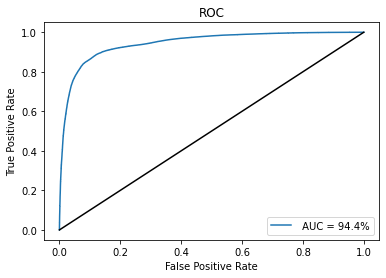

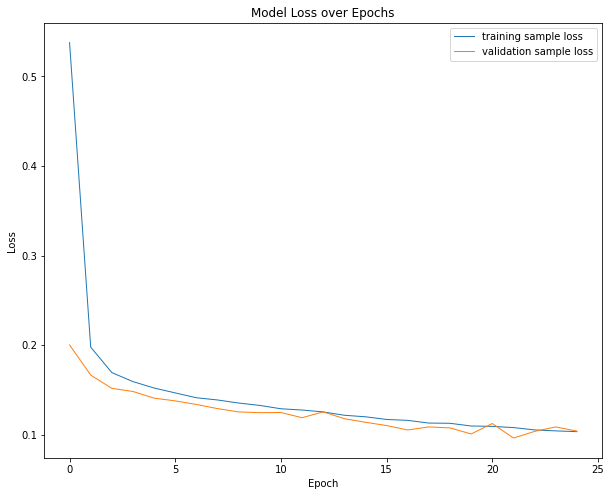

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.3531 - tp: 123.0000 - fp: 1131.0000 - tn: 75171.0000 - fn: 3575.0000 - accuracy: 0.9412 - precision: 0.0981 - recall: 0.0333 - auc: 0.5360 - val_loss: 0.1914 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6974
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1912 - tp: 21.0000 - fp: 76.0000 - tn: 76226.0000 - fn: 3677.0000 - accuracy: 0.9531 - precision: 0.2165 - recall: 0.0057 - auc: 0.6927 - val_loss: 0.1599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8292
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1664 - tp: 1.0000 - fp: 42.0000 - tn

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1032 - tp: 1428.0000 - fp: 702.0000 - tn: 75600.0000 - fn: 2270.0000 - accuracy: 0.9628 - precision: 0.6704 - recall: 0.3862 - auc: 0.9313 - val_loss: 0.1043 - val_tp: 311.0000 - val_fp: 69.0000 - val_tn: 18987.0000 - val_fn: 633.0000 - val_accuracy: 0.9649 - val_precision: 0.8184 - val_recall: 0.3294 - val_auc: 0.9303
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1024 - tp: 1453.0000 - fp: 715.0000 - tn: 75587.0000 - fn: 2245.0000 - accuracy: 0.9630 - precision: 0.6702 - recall: 0.3929 - auc: 0.9333 - val_loss: 0.1048 - val_tp: 359.0000 - val_fp: 131.0000 - val_tn: 18925.0000 - val_fn: 585.0000 - val_accuracy: 0.9642 - val_precision: 0.7327 - val_recall: 0.3803 - val_auc: 0.9331
Epoch 23/25
80000/80000 [==============================] - 3s 43us/sample - loss: 0.1007 - tp: 1521.0000 - fp: 721.0000 - tn: 75581.0000 - fn: 2177.0000 - accuracy: 0.9638 - precision: 0.67

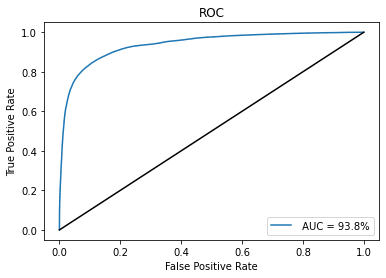

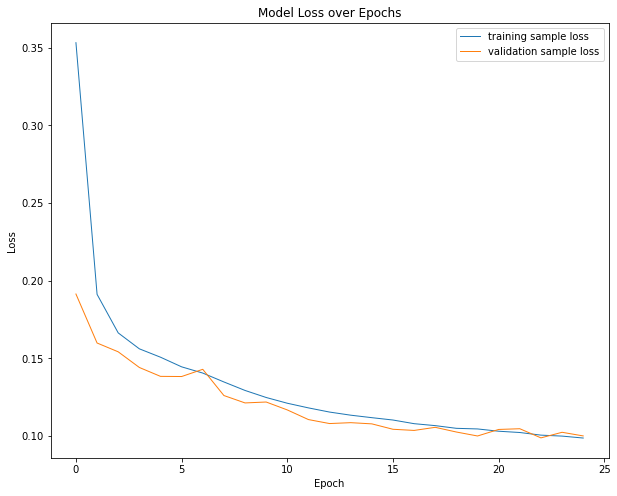

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 61us/sample - loss: 0.3552 - tp: 103.0000 - fp: 1097.0000 - tn: 75205.0000 - fn: 3595.0000 - accuracy: 0.9413 - precision: 0.0858 - recall: 0.0279 - auc: 0.5231 - val_loss: 0.1901 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7386
Epoch 2/25
80000/80000 [==============================] - 3s 39us/sample - loss: 0.1864 - tp: 5.0000 - fp: 59.0000 - tn: 76243.0000 - fn: 3693.0000 - accuracy: 0.9531 - precision: 0.0781 - recall: 0.0014 - auc: 0.7015 - val_loss: 0.1646 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8088
Epoch 3/25
80000/80000 [==============================] - 3s 42us/sample - loss: 0.1652 - tp: 17.0000 - fp: 77.0000 - tn

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0990 - tp: 1629.0000 - fp: 658.0000 - tn: 75644.0000 - fn: 2069.0000 - accuracy: 0.9659 - precision: 0.7123 - recall: 0.4405 - auc: 0.9331 - val_loss: 0.1029 - val_tp: 429.0000 - val_fp: 154.0000 - val_tn: 18902.0000 - val_fn: 515.0000 - val_accuracy: 0.9665 - val_precision: 0.7358 - val_recall: 0.4544 - val_auc: 0.9327
Epoch 22/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.0987 - tp: 1671.0000 - fp: 689.0000 - tn: 75613.0000 - fn: 2027.0000 - accuracy: 0.9661 - precision: 0.7081 - recall: 0.4519 - auc: 0.9328 - val_loss: 0.1007 - val_tp: 604.0000 - val_fp: 400.0000 - val_tn: 18656.0000 - val_fn: 340.0000 - val_accuracy: 0.9630 - val_precision: 0.6016 - val_recall: 0.6398 - val_auc: 0.9405
Epoch 23/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0971 - tp: 1705.0000 - fp: 710.0000 - tn: 75592.0000 - fn: 1993.0000 - accuracy: 0.9662 - precision: 0.7

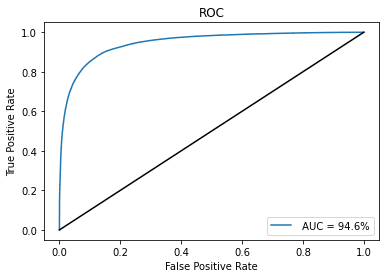

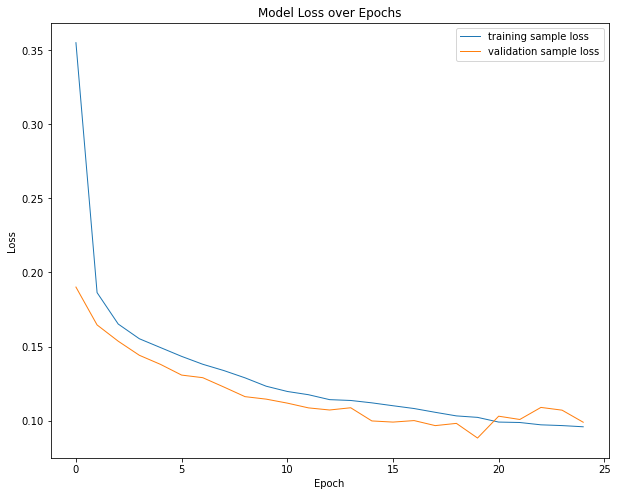

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 60us/sample - loss: 0.4581 - tp: 141.0000 - fp: 1904.0000 - tn: 74398.0000 - fn: 3557.0000 - accuracy: 0.9317 - precision: 0.0689 - recall: 0.0381 - auc: 0.5180 - val_loss: 0.2192 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7137
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2039 - tp: 9.0000 - fp: 82.0000 - tn: 76220.0000 - fn: 3689.0000 - accuracy: 0.9529 - precision: 0.0989 - recall: 0.0024 - auc: 0.6744 - val_loss: 0.1663 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8135
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1676 - tp: 4.0000 - fp: 51.0000 - tn:

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1048 - tp: 1443.0000 - fp: 757.0000 - tn: 75545.0000 - fn: 2255.0000 - accuracy: 0.9624 - precision: 0.6559 - recall: 0.3902 - auc: 0.9251 - val_loss: 0.1132 - val_tp: 440.0000 - val_fp: 302.0000 - val_tn: 18754.0000 - val_fn: 504.0000 - val_accuracy: 0.9597 - val_precision: 0.5930 - val_recall: 0.4661 - val_auc: 0.9248
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1038 - tp: 1504.0000 - fp: 738.0000 - tn: 75564.0000 - fn: 2194.0000 - accuracy: 0.9633 - precision: 0.6708 - recall: 0.4067 - auc: 0.9258 - val_loss: 0.1109 - val_tp: 521.0000 - val_fp: 424.0000 - val_tn: 18632.0000 - val_fn: 423.0000 - val_accuracy: 0.9577 - val_precision: 0.5513 - val_recall: 0.5519 - val_auc: 0.9330
Epoch 23/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1013 - tp: 1626.0000 - fp: 755.0000 - tn: 75547.0000 - fn: 2072.0000 - accuracy: 0.9647 - precision: 0.6

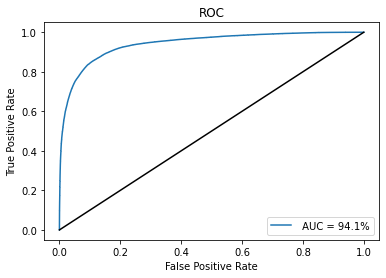

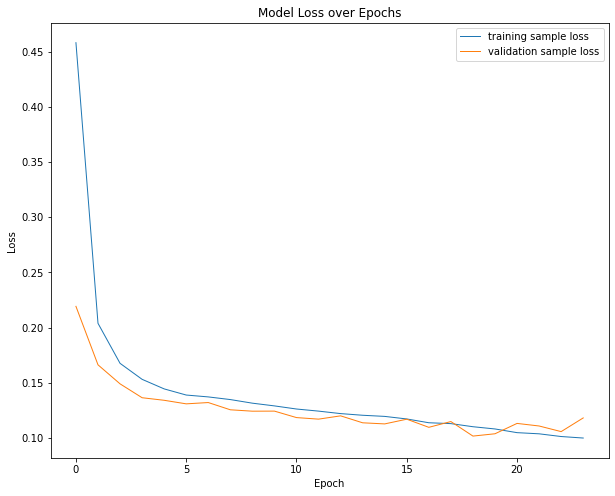

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 65us/sample - loss: 0.2728 - tp: 88.0000 - fp: 788.0000 - tn: 75514.0000 - fn: 3610.0000 - accuracy: 0.9450 - precision: 0.1005 - recall: 0.0238 - auc: 0.5791 - val_loss: 0.1723 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7715
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1716 - tp: 7.0000 - fp: 47.0000 - tn: 76255.0000 - fn: 3691.0000 - accuracy: 0.9533 - precision: 0.1296 - recall: 0.0019 - auc: 0.7580 - val_loss: 0.1493 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19056.0000 - val_fn: 944.0000 - val_accuracy: 0.9528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8454
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1578 - tp: 1.0000 - fp: 19.0000 - tn: 7

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.0961 - tp: 1761.0000 - fp: 729.0000 - tn: 75573.0000 - fn: 1937.0000 - accuracy: 0.9667 - precision: 0.7072 - recall: 0.4762 - auc: 0.9383 - val_loss: 0.1044 - val_tp: 353.0000 - val_fp: 141.0000 - val_tn: 18915.0000 - val_fn: 591.0000 - val_accuracy: 0.9634 - val_precision: 0.7146 - val_recall: 0.3739 - val_auc: 0.9334
Epoch 22/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.0938 - tp: 1824.0000 - fp: 712.0000 - tn: 75590.0000 - fn: 1874.0000 - accuracy: 0.9677 - precision: 0.7192 - recall: 0.4932 - auc: 0.9408 - val_loss: 0.1235 - val_tp: 461.0000 - val_fp: 447.0000 - val_tn: 18609.0000 - val_fn: 483.0000 - val_accuracy: 0.9535 - val_precision: 0.5077 - val_recall: 0.4883 - val_auc: 0.9205
Epoch 23/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.0937 - tp: 1819.0000 - fp: 706.0000 - tn: 75596.0000 - fn: 1879.0000 - accuracy: 0.9677 - precision: 0.7

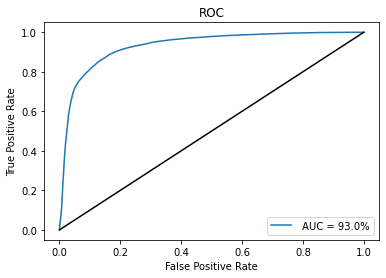

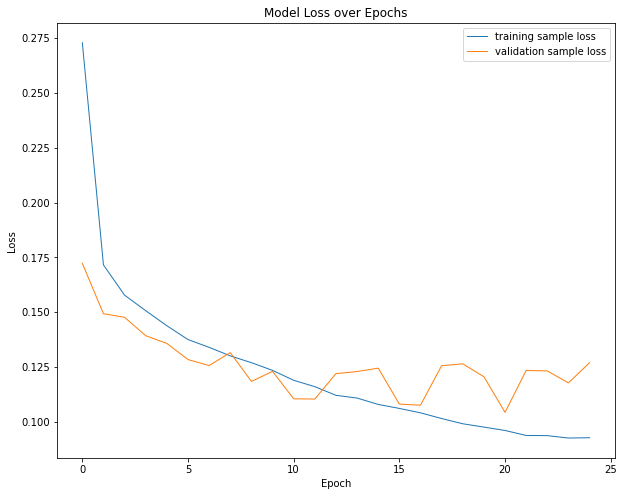

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.6005 - tp: 553.0000 - fp: 2762.0000 - tn: 69241.0000 - fn: 7444.0000 - accuracy: 0.8724 - precision: 0.1668 - recall: 0.0692 - auc: 0.5440 - val_loss: 0.3258 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7395
Epoch 2/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.3164 - tp: 87.0000 - fp: 175.0000 - tn: 71828.0000 - fn: 7910.0000 - accuracy: 0.8989 - precision: 0.3321 - recall: 0.0109 - auc: 0.7255 - val_loss: 0.2737 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 17995.0000 - val_fn: 2003.0000 - val_accuracy: 0.8997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8264
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2772 - tp: 223.0000 - fp: 327.0000 - 

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1496 - tp: 5099.0000 - fp: 1341.0000 - tn: 70662.0000 - fn: 2898.0000 - accuracy: 0.9470 - precision: 0.7918 - recall: 0.6376 - auc: 0.9423 - val_loss: 0.1594 - val_tp: 1367.0000 - val_fp: 610.0000 - val_tn: 17387.0000 - val_fn: 636.0000 - val_accuracy: 0.9377 - val_precision: 0.6915 - val_recall: 0.6825 - val_auc: 0.9456
Epoch 00021: early stopping


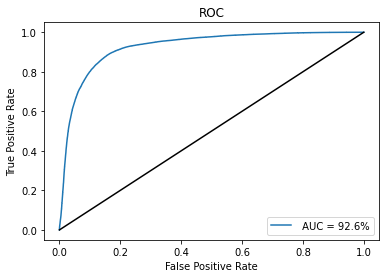

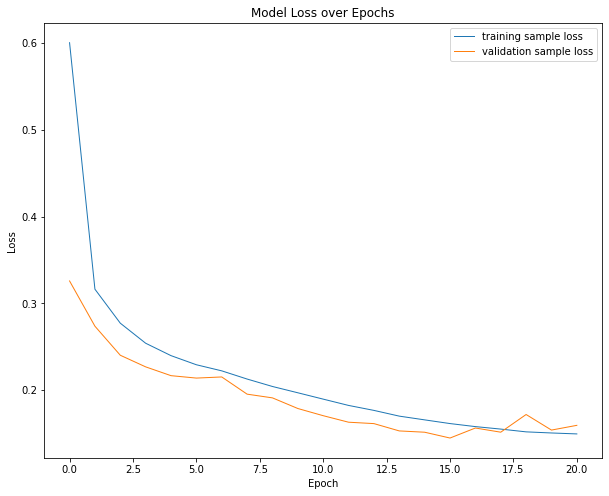

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.4672 - tp: 518.0000 - fp: 2228.0000 - tn: 69775.0000 - fn: 7479.0000 - accuracy: 0.8787 - precision: 0.1886 - recall: 0.0648 - auc: 0.5896 - val_loss: 0.2852 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8097
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2902 - tp: 124.0000 - fp: 354.0000 - tn: 71649.0000 - fn: 7873.0000 - accuracy: 0.8972 - precision: 0.2594 - recall: 0.0155 - auc: 0.7671 - val_loss: 0.2598 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8311
Epoch 3/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.2624 - tp: 159.0000 - fp: 537.00

Epoch 21/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.1531 - tp: 5043.0000 - fp: 1444.0000 - tn: 70559.0000 - fn: 2954.0000 - accuracy: 0.9450 - precision: 0.7774 - recall: 0.6306 - auc: 0.9414 - val_loss: 0.1380 - val_tp: 1416.0000 - val_fp: 353.0000 - val_tn: 17644.0000 - val_fn: 587.0000 - val_accuracy: 0.9530 - val_precision: 0.8005 - val_recall: 0.7069 - val_auc: 0.9530
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.1512 - tp: 5002.0000 - fp: 1258.0000 - tn: 70745.0000 - fn: 2995.0000 - accuracy: 0.9468 - precision: 0.7990 - recall: 0.6255 - auc: 0.9428 - val_loss: 0.1636 - val_tp: 1440.0000 - val_fp: 708.0000 - val_tn: 17289.0000 - val_fn: 563.0000 - val_accuracy: 0.9365 - val_precision: 0.6704 - val_recall: 0.7189 - val_auc: 0.9464
Epoch 23/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1501 - tp: 5096.0000 - fp: 1394.0000 - tn: 70609.0000 - fn: 2901.0000 - accuracy: 0.9463 - precision

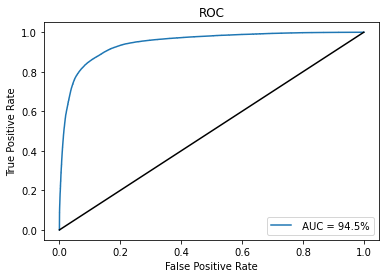

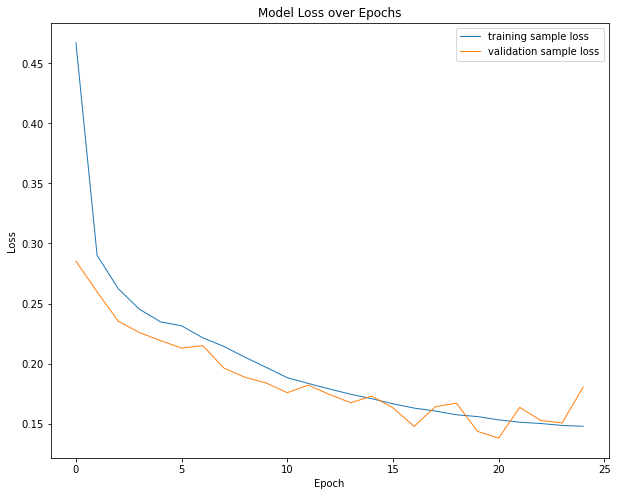

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 67us/sample - loss: 0.5495 - tp: 836.0000 - fp: 3289.0000 - tn: 68714.0000 - fn: 7161.0000 - accuracy: 0.8694 - precision: 0.2027 - recall: 0.1045 - auc: 0.5838 - val_loss: 0.2805 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8106
Epoch 2/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.2858 - tp: 356.0000 - fp: 665.0000 - tn: 71338.0000 - fn: 7641.0000 - accuracy: 0.8962 - precision: 0.3487 - recall: 0.0445 - auc: 0.7754 - val_loss: 0.2562 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 17994.0000 - val_fn: 2003.0000 - val_accuracy: 0.8997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8234
Epoch 3/25
80000/80000 [==============================] - 3s 39us/sample - loss: 0.2541 - tp: 699.0000 - fp: 942.0000 -

Epoch 21/25
80000/80000 [==============================] - 4s 44us/sample - loss: 0.1475 - tp: 5223.0000 - fp: 1351.0000 - tn: 70652.0000 - fn: 2774.0000 - accuracy: 0.9484 - precision: 0.7945 - recall: 0.6531 - auc: 0.9435 - val_loss: 0.1684 - val_tp: 1111.0000 - val_fp: 282.0000 - val_tn: 17715.0000 - val_fn: 892.0000 - val_accuracy: 0.9413 - val_precision: 0.7976 - val_recall: 0.5547 - val_auc: 0.9365
Epoch 22/25
80000/80000 [==============================] - 4s 44us/sample - loss: 0.1467 - tp: 5215.0000 - fp: 1296.0000 - tn: 70707.0000 - fn: 2782.0000 - accuracy: 0.9490 - precision: 0.8010 - recall: 0.6521 - auc: 0.9445 - val_loss: 0.1710 - val_tp: 1301.0000 - val_fp: 612.0000 - val_tn: 17385.0000 - val_fn: 702.0000 - val_accuracy: 0.9343 - val_precision: 0.6801 - val_recall: 0.6495 - val_auc: 0.9370
Epoch 23/25
80000/80000 [==============================] - 3s 43us/sample - loss: 0.1462 - tp: 5228.0000 - fp: 1278.0000 - tn: 70725.0000 - fn: 2769.0000 - accuracy: 0.9494 - precision

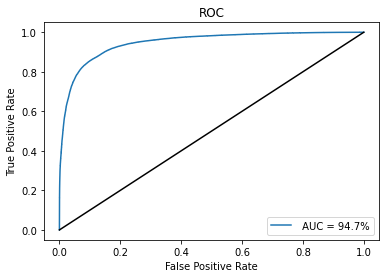

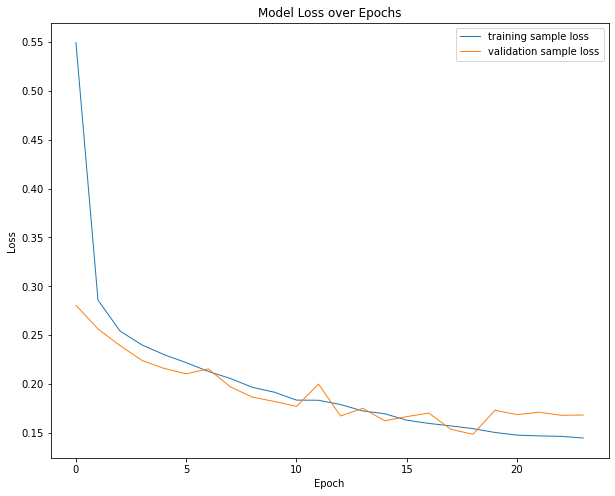

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.5613 - tp: 777.0000 - fp: 3175.0000 - tn: 68828.0000 - fn: 7220.0000 - accuracy: 0.8701 - precision: 0.1966 - recall: 0.0972 - auc: 0.5859 - val_loss: 0.3019 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7961
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.3019 - tp: 140.0000 - fp: 371.0000 - tn: 71632.0000 - fn: 7857.0000 - accuracy: 0.8971 - precision: 0.2740 - recall: 0.0175 - auc: 0.7462 - val_loss: 0.2577 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8488
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2667 - tp: 193.0000 - fp: 454.00

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.1455 - tp: 5221.0000 - fp: 1311.0000 - tn: 70692.0000 - fn: 2776.0000 - accuracy: 0.9489 - precision: 0.7993 - recall: 0.6529 - auc: 0.9459 - val_loss: 0.1592 - val_tp: 1381.0000 - val_fp: 567.0000 - val_tn: 17430.0000 - val_fn: 622.0000 - val_accuracy: 0.9406 - val_precision: 0.7089 - val_recall: 0.6895 - val_auc: 0.9453
Epoch 22/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.1458 - tp: 5284.0000 - fp: 1344.0000 - tn: 70659.0000 - fn: 2713.0000 - accuracy: 0.9493 - precision: 0.7972 - recall: 0.6607 - auc: 0.9443 - val_loss: 0.1500 - val_tp: 1432.0000 - val_fp: 537.0000 - val_tn: 17460.0000 - val_fn: 571.0000 - val_accuracy: 0.9446 - val_precision: 0.7273 - val_recall: 0.7149 - val_auc: 0.9513
Epoch 00022: early stopping


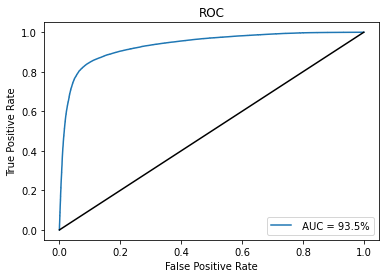

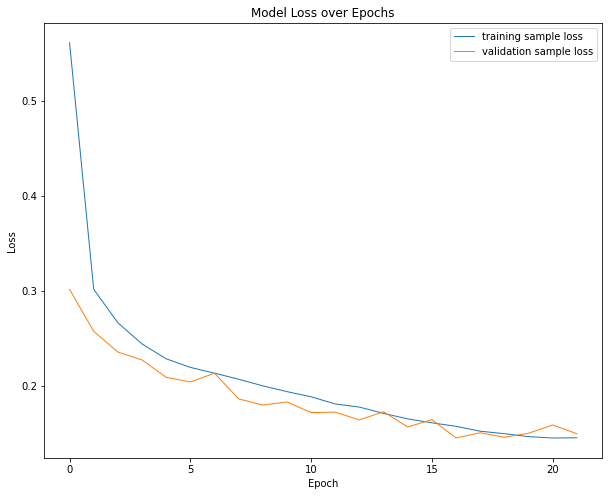

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 60us/sample - loss: 0.5033 - tp: 576.0000 - fp: 2469.0000 - tn: 69534.0000 - fn: 7421.0000 - accuracy: 0.8764 - precision: 0.1892 - recall: 0.0720 - auc: 0.5930 - val_loss: 0.2955 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7972
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2882 - tp: 125.0000 - fp: 413.0000 - tn: 71590.0000 - fn: 7872.0000 - accuracy: 0.8964 - precision: 0.2323 - recall: 0.0156 - auc: 0.7715 - val_loss: 0.2479 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 17997.0000 - val_fn: 2003.0000 - val_accuracy: 0.8999 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8575
Epoch 3/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.2584 - tp: 283.0000 - fp: 658.00

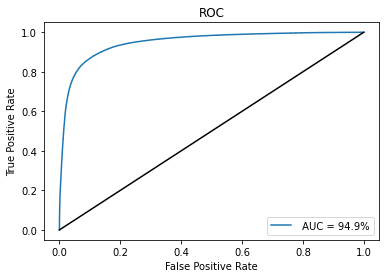

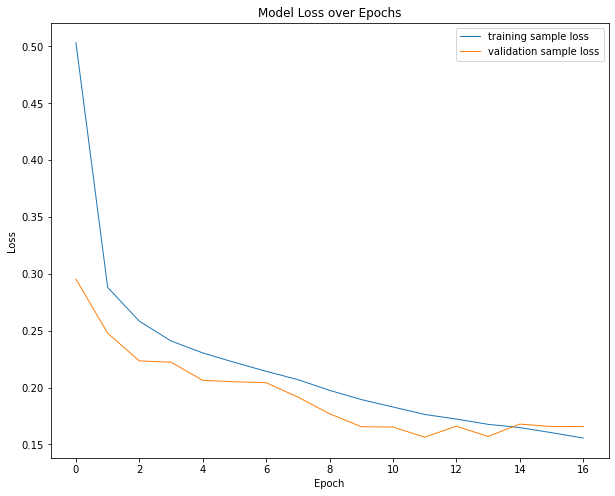

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.6702 - tp: 4278.0000 - fp: 6367.0000 - tn: 56506.0000 - fn: 12849.0000 - accuracy: 0.7598 - precision: 0.4019 - recall: 0.2498 - auc: 0.6562 - val_loss: 0.4230 - val_tp: 9.0000 - val_fp: 61.0000 - val_tn: 15522.0000 - val_fn: 4408.0000 - val_accuracy: 0.7765 - val_precision: 0.1286 - val_recall: 0.0020 - val_auc: 0.8241
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4193 - tp: 4969.0000 - fp: 3640.0000 - tn: 59233.0000 - fn: 12158.0000 - accuracy: 0.8025 - precision: 0.5772 - recall: 0.2901 - auc: 0.8049 - val_loss: 0.3699 - val_tp: 1118.0000 - val_fp: 277.0000 - val_tn: 15306.0000 - val_fn: 3299.0000 - val_accuracy: 0.8212 - val_precision: 0.8014 - val_recall: 0.2531 - val_auc: 0.8613
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.3804 - tp: 6783.0000 - fp: 3991.0000 - tn: 58882.0000

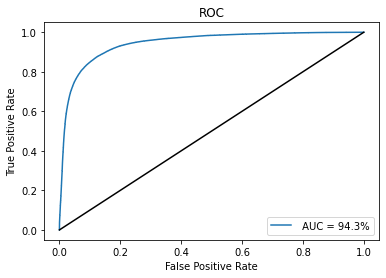

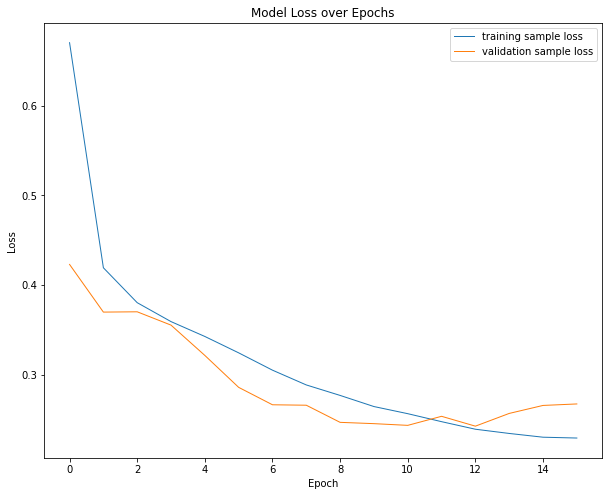

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.7023 - tp: 5099.0000 - fp: 6964.0000 - tn: 55909.0000 - fn: 12028.0000 - accuracy: 0.7626 - precision: 0.4227 - recall: 0.2977 - auc: 0.6568 - val_loss: 0.3988 - val_tp: 953.0000 - val_fp: 335.0000 - val_tn: 15248.0000 - val_fn: 3464.0000 - val_accuracy: 0.8101 - val_precision: 0.7399 - val_recall: 0.2158 - val_auc: 0.8525
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4077 - tp: 7056.0000 - fp: 4297.0000 - tn: 58576.0000 - fn: 10071.0000 - accuracy: 0.8204 - precision: 0.6215 - recall: 0.4120 - auc: 0.8197 - val_loss: 0.3543 - val_tp: 1826.0000 - val_fp: 604.0000 - val_tn: 14979.0000 - val_fn: 2591.0000 - val_accuracy: 0.8403 - val_precision: 0.7514 - val_recall: 0.4134 - val_auc: 0.8755
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.3660 - tp: 9308.0000 - fp: 4563.0000 - tn: 58310.0

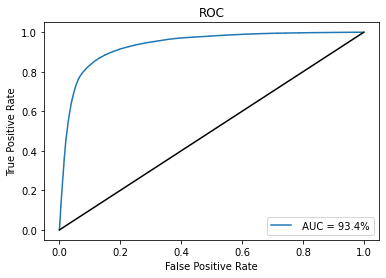

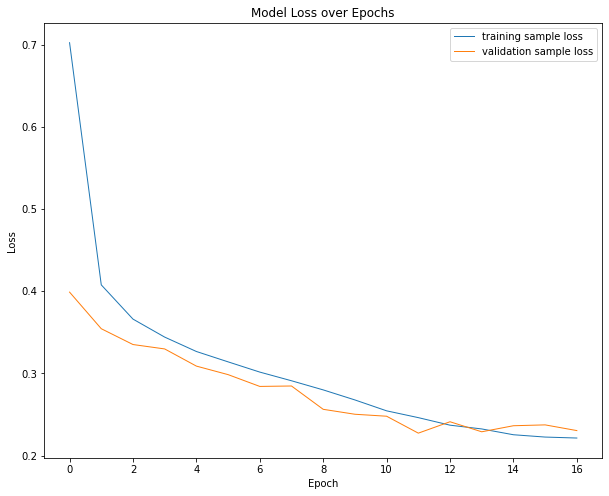

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 0.6700 - tp: 4547.0000 - fp: 6455.0000 - tn: 56418.0000 - fn: 12580.0000 - accuracy: 0.7621 - precision: 0.4133 - recall: 0.2655 - auc: 0.6504 - val_loss: 0.4232 - val_tp: 21.0000 - val_fp: 182.0000 - val_tn: 15401.0000 - val_fn: 4396.0000 - val_accuracy: 0.7711 - val_precision: 0.1034 - val_recall: 0.0048 - val_auc: 0.8513
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4289 - tp: 5119.0000 - fp: 3865.0000 - tn: 59008.0000 - fn: 12008.0000 - accuracy: 0.8016 - precision: 0.5698 - recall: 0.2989 - auc: 0.7964 - val_loss: 0.3714 - val_tp: 2219.0000 - val_fp: 699.0000 - val_tn: 14884.0000 - val_fn: 2198.0000 - val_accuracy: 0.8551 - val_precision: 0.7605 - val_recall: 0.5024 - val_auc: 0.8667
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.3904 - tp: 6690.0000 - fp: 4113.0000 - tn: 58760.00

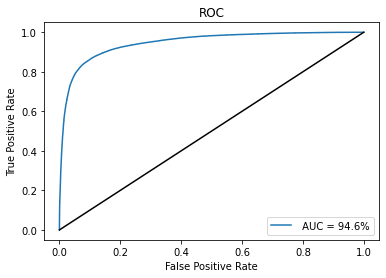

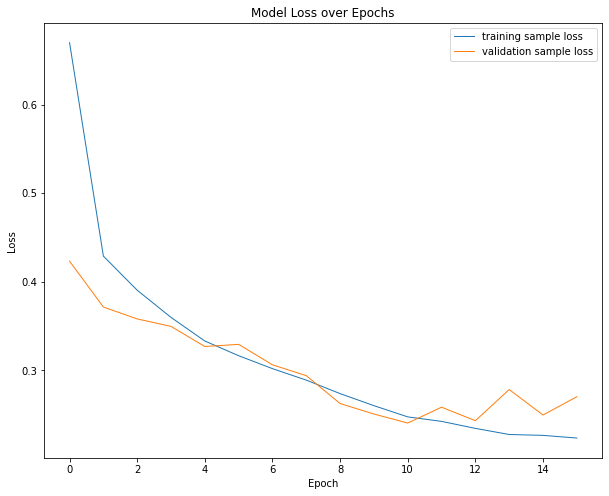

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.6899 - tp: 4678.0000 - fp: 6505.0000 - tn: 56368.0000 - fn: 12449.0000 - accuracy: 0.7631 - precision: 0.4183 - recall: 0.2731 - auc: 0.6561 - val_loss: 0.4241 - val_tp: 13.0000 - val_fp: 129.0000 - val_tn: 15454.0000 - val_fn: 4404.0000 - val_accuracy: 0.7734 - val_precision: 0.0915 - val_recall: 0.0029 - val_auc: 0.8272
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4158 - tp: 5943.0000 - fp: 4050.0000 - tn: 58823.0000 - fn: 11184.0000 - accuracy: 0.8096 - precision: 0.5947 - recall: 0.3470 - auc: 0.8114 - val_loss: 0.3609 - val_tp: 1583.0000 - val_fp: 753.0000 - val_tn: 14830.0000 - val_fn: 2834.0000 - val_accuracy: 0.8206 - val_precision: 0.6777 - val_recall: 0.3584 - val_auc: 0.8661
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.3714 - tp: 8524.0000 - fp: 4470.0000 - tn: 58403.00

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2183 - tp: 12934.0000 - fp: 2307.0000 - tn: 60566.0000 - fn: 4193.0000 - accuracy: 0.9187 - precision: 0.8486 - recall: 0.7552 - auc: 0.9477 - val_loss: 0.2347 - val_tp: 3468.0000 - val_fp: 792.0000 - val_tn: 14791.0000 - val_fn: 949.0000 - val_accuracy: 0.9129 - val_precision: 0.8141 - val_recall: 0.7851 - val_auc: 0.9498
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2161 - tp: 12949.0000 - fp: 2196.0000 - tn: 60677.0000 - fn: 4178.0000 - accuracy: 0.9203 - precision: 0.8550 - recall: 0.7561 - auc: 0.9488 - val_loss: 0.2462 - val_tp: 3295.0000 - val_fp: 815.0000 - val_tn: 14768.0000 - val_fn: 1122.0000 - val_accuracy: 0.9032 - val_precision: 0.8017 - val_recall: 0.7460 - val_auc: 0.9429
Epoch 23/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2136 - tp: 12925.0000 - fp: 2188.0000 - tn: 60685.0000 - fn: 4202.0000 - accuracy: 0.9201 - preci

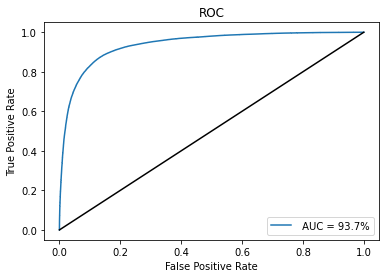

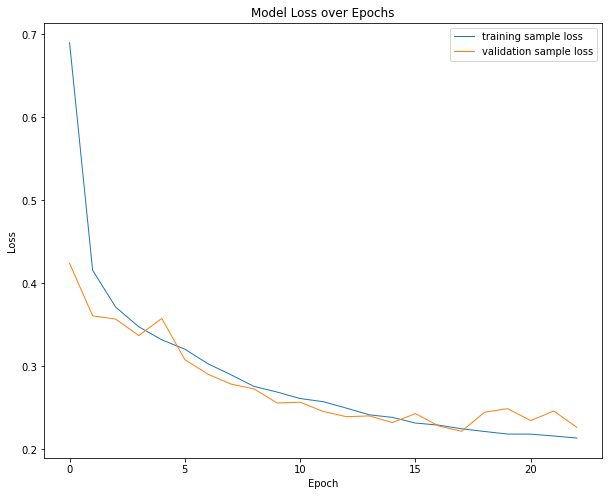

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 66us/sample - loss: 0.7560 - tp: 4545.0000 - fp: 6599.0000 - tn: 56274.0000 - fn: 12582.0000 - accuracy: 0.7602 - precision: 0.4078 - recall: 0.2654 - auc: 0.6481 - val_loss: 0.4384 - val_tp: 1.0000 - val_fp: 44.0000 - val_tn: 15539.0000 - val_fn: 4416.0000 - val_accuracy: 0.7770 - val_precision: 0.0222 - val_recall: 2.2640e-04 - val_auc: 0.8185
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4316 - tp: 4518.0000 - fp: 3848.0000 - tn: 59025.0000 - fn: 12609.0000 - accuracy: 0.7943 - precision: 0.5400 - recall: 0.2638 - auc: 0.7958 - val_loss: 0.3808 - val_tp: 1342.0000 - val_fp: 517.0000 - val_tn: 15066.0000 - val_fn: 3075.0000 - val_accuracy: 0.8204 - val_precision: 0.7219 - val_recall: 0.3038 - val_auc: 0.8618
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.3877 - tp: 7408.0000 - fp: 4385.0000 - tn: 58488.

Epoch 00020: early stopping


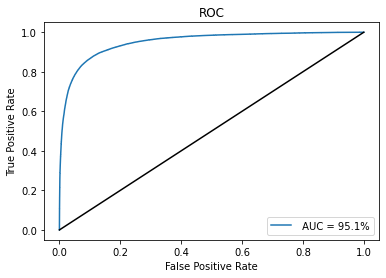

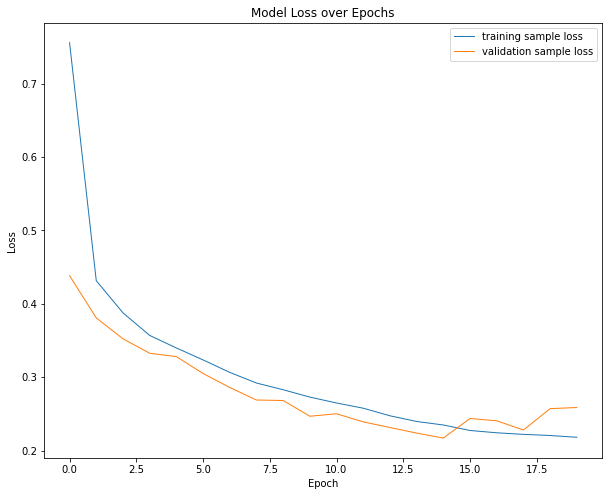

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.8000 - tp: 27265.0000 - fp: 15750.0000 - tn: 27252.0000 - fn: 9733.0000 - accuracy: 0.6815 - precision: 0.6338 - recall: 0.7369 - auc: 0.7192 - val_loss: 0.5259 - val_tp: 8208.0000 - val_fp: 3372.0000 - val_tn: 7210.0000 - val_fn: 1210.0000 - val_accuracy: 0.7709 - val_precision: 0.7088 - val_recall: 0.8715 - val_auc: 0.8496
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5186 - tp: 29814.0000 - fp: 10340.0000 - tn: 32662.0000 - fn: 7184.0000 - accuracy: 0.7810 - precision: 0.7425 - recall: 0.8058 - auc: 0.8308 - val_loss: 0.4590 - val_tp: 7425.0000 - val_fp: 1396.0000 - val_tn: 9186.0000 - val_fn: 1993.0000 - val_accuracy: 0.8306 - val_precision: 0.8417 - val_recall: 0.7884 - val_auc: 0.8733
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4614 - tp: 29718.0000 - fp: 7561.0000 - tn: 354

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2845 - tp: 31640.0000 - fp: 3738.0000 - tn: 39264.0000 - fn: 5358.0000 - accuracy: 0.8863 - precision: 0.8943 - recall: 0.8552 - auc: 0.9488 - val_loss: 0.3100 - val_tp: 8022.0000 - val_fp: 1032.0000 - val_tn: 9550.0000 - val_fn: 1396.0000 - val_accuracy: 0.8786 - val_precision: 0.8860 - val_recall: 0.8518 - val_auc: 0.9419
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2832 - tp: 31673.0000 - fp: 3767.0000 - tn: 39235.0000 - fn: 5325.0000 - accuracy: 0.8863 - precision: 0.8937 - recall: 0.8561 - auc: 0.9492 - val_loss: 0.3027 - val_tp: 8180.0000 - val_fp: 1134.0000 - val_tn: 9448.0000 - val_fn: 1238.0000 - val_accuracy: 0.8814 - val_precision: 0.8782 - val_recall: 0.8685 - val_auc: 0.9457
Epoch 00022: early stopping


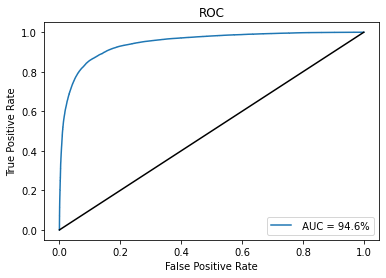

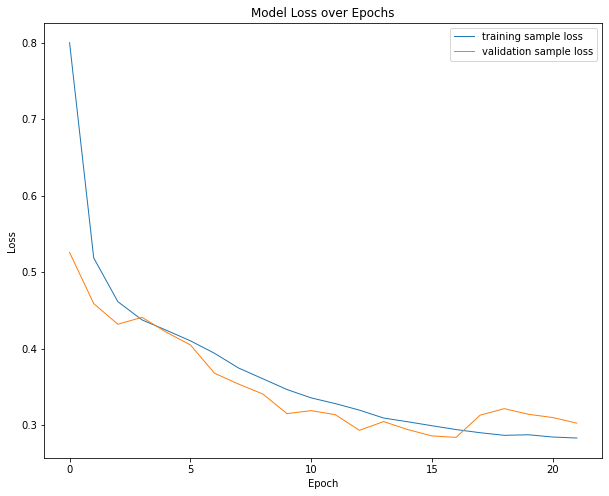

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.9808 - tp: 25322.0000 - fp: 15001.0000 - tn: 28001.0000 - fn: 11676.0000 - accuracy: 0.6665 - precision: 0.6280 - recall: 0.6844 - auc: 0.6866 - val_loss: 0.5311 - val_tp: 8150.0000 - val_fp: 2766.0000 - val_tn: 7816.0000 - val_fn: 1268.0000 - val_accuracy: 0.7983 - val_precision: 0.7466 - val_recall: 0.8654 - val_auc: 0.8420
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5326 - tp: 28649.0000 - fp: 10164.0000 - tn: 32838.0000 - fn: 8349.0000 - accuracy: 0.7686 - precision: 0.7381 - recall: 0.7743 - auc: 0.8186 - val_loss: 0.4477 - val_tp: 7900.0000 - val_fp: 1824.0000 - val_tn: 8758.0000 - val_fn: 1518.0000 - val_accuracy: 0.8329 - val_precision: 0.8124 - val_recall: 0.8388 - val_auc: 0.8771
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4712 - tp: 29663.0000 - fp: 7915.0000 - tn: 35

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2863 - tp: 31630.0000 - fp: 3976.0000 - tn: 39026.0000 - fn: 5368.0000 - accuracy: 0.8832 - precision: 0.8883 - recall: 0.8549 - auc: 0.9483 - val_loss: 0.2878 - val_tp: 8206.0000 - val_fp: 1029.0000 - val_tn: 9553.0000 - val_fn: 1212.0000 - val_accuracy: 0.8880 - val_precision: 0.8886 - val_recall: 0.8713 - val_auc: 0.9505
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2831 - tp: 31681.0000 - fp: 3893.0000 - tn: 39109.0000 - fn: 5317.0000 - accuracy: 0.8849 - precision: 0.8906 - recall: 0.8563 - auc: 0.9495 - val_loss: 0.2714 - val_tp: 8084.0000 - val_fp: 948.0000 - val_tn: 9634.0000 - val_fn: 1334.0000 - val_accuracy: 0.8859 - val_precision: 0.8950 - val_recall: 0.8584 - val_auc: 0.9544
Epoch 23/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2802 - tp: 31798.0000 - fp: 3869.0000 - tn: 39133.0000 - fn: 5200.0000 - accuracy: 0.8866 - preci

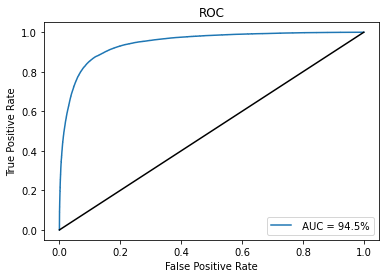

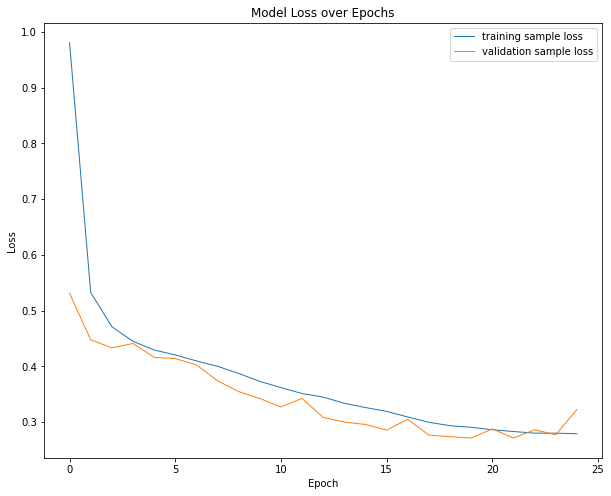

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 57us/sample - loss: 1.0712 - tp: 26224.0000 - fp: 16029.0000 - tn: 26973.0000 - fn: 10774.0000 - accuracy: 0.6650 - precision: 0.6206 - recall: 0.7088 - auc: 0.6935 - val_loss: 0.5332 - val_tp: 8093.0000 - val_fp: 3127.0000 - val_tn: 7455.0000 - val_fn: 1325.0000 - val_accuracy: 0.7774 - val_precision: 0.7213 - val_recall: 0.8593 - val_auc: 0.8367
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5556 - tp: 29609.0000 - fp: 11843.0000 - tn: 31159.0000 - fn: 7389.0000 - accuracy: 0.7596 - precision: 0.7143 - recall: 0.8003 - auc: 0.8063 - val_loss: 0.4870 - val_tp: 7868.0000 - val_fp: 1884.0000 - val_tn: 8698.0000 - val_fn: 1550.0000 - val_accuracy: 0.8283 - val_precision: 0.8068 - val_recall: 0.8354 - val_auc: 0.8602
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4975 - tp: 29486.0000 - fp: 8808.0000 - tn: 34

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2833 - tp: 31669.0000 - fp: 3823.0000 - tn: 39179.0000 - fn: 5329.0000 - accuracy: 0.8856 - precision: 0.8923 - recall: 0.8560 - auc: 0.9493 - val_loss: 0.3031 - val_tp: 8193.0000 - val_fp: 1223.0000 - val_tn: 9359.0000 - val_fn: 1225.0000 - val_accuracy: 0.8776 - val_precision: 0.8701 - val_recall: 0.8699 - val_auc: 0.9442
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2822 - tp: 31734.0000 - fp: 3830.0000 - tn: 39172.0000 - fn: 5264.0000 - accuracy: 0.8863 - precision: 0.8923 - recall: 0.8577 - auc: 0.9495 - val_loss: 0.3128 - val_tp: 7418.0000 - val_fp: 699.0000 - val_tn: 9883.0000 - val_fn: 2000.0000 - val_accuracy: 0.8651 - val_precision: 0.9139 - val_recall: 0.7876 - val_auc: 0.9440
Epoch 23/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2788 - tp: 31739.0000 - fp: 3763.0000 - tn: 39239.0000 - fn: 5259.0000 - accuracy: 0.8872 - preci

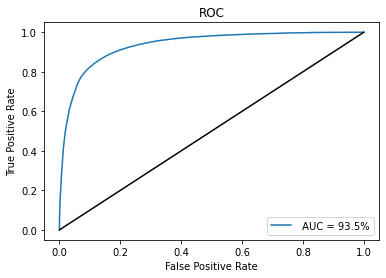

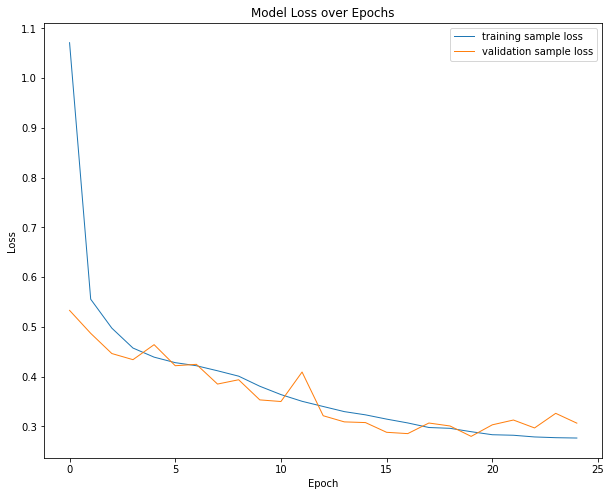

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 67us/sample - loss: 0.8936 - tp: 26059.0000 - fp: 14553.0000 - tn: 28449.0000 - fn: 10939.0000 - accuracy: 0.6813 - precision: 0.6417 - recall: 0.7043 - auc: 0.7063 - val_loss: 0.5249 - val_tp: 7895.0000 - val_fp: 2246.0000 - val_tn: 8336.0000 - val_fn: 1523.0000 - val_accuracy: 0.8116 - val_precision: 0.7785 - val_recall: 0.8383 - val_auc: 0.8427
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5274 - tp: 28983.0000 - fp: 9880.0000 - tn: 33122.0000 - fn: 8015.0000 - accuracy: 0.7763 - precision: 0.7458 - recall: 0.7834 - auc: 0.8225 - val_loss: 0.4675 - val_tp: 7744.0000 - val_fp: 1794.0000 - val_tn: 8788.0000 - val_fn: 1674.0000 - val_accuracy: 0.8266 - val_precision: 0.8119 - val_recall: 0.8223 - val_auc: 0.8726
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4822 - tp: 29514.0000 - fp: 8200.0000 - tn: 348

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2882 - tp: 31609.0000 - fp: 3952.0000 - tn: 39050.0000 - fn: 5389.0000 - accuracy: 0.8832 - precision: 0.8889 - recall: 0.8543 - auc: 0.9478 - val_loss: 0.2955 - val_tp: 8269.0000 - val_fp: 1181.0000 - val_tn: 9401.0000 - val_fn: 1149.0000 - val_accuracy: 0.8835 - val_precision: 0.8750 - val_recall: 0.8780 - val_auc: 0.9495
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2865 - tp: 31572.0000 - fp: 3850.0000 - tn: 39152.0000 - fn: 5426.0000 - accuracy: 0.8841 - precision: 0.8913 - recall: 0.8533 - auc: 0.9483 - val_loss: 0.3121 - val_tp: 7835.0000 - val_fp: 897.0000 - val_tn: 9685.0000 - val_fn: 1583.0000 - val_accuracy: 0.8760 - val_precision: 0.8973 - val_recall: 0.8319 - val_auc: 0.9418
Epoch 00022: early stopping


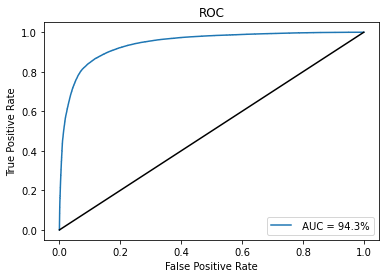

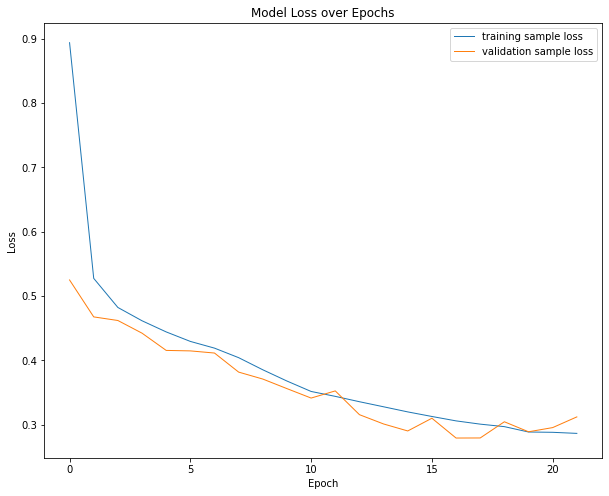

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 1.0452 - tp: 26281.0000 - fp: 15161.0000 - tn: 27841.0000 - fn: 10717.0000 - accuracy: 0.6765 - precision: 0.6342 - recall: 0.7103 - auc: 0.6969 - val_loss: 0.5365 - val_tp: 8037.0000 - val_fp: 2833.0000 - val_tn: 7749.0000 - val_fn: 1381.0000 - val_accuracy: 0.7893 - val_precision: 0.7394 - val_recall: 0.8534 - val_auc: 0.8304
Epoch 2/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.5411 - tp: 29765.0000 - fp: 11316.0000 - tn: 31686.0000 - fn: 7233.0000 - accuracy: 0.7681 - precision: 0.7245 - recall: 0.8045 - auc: 0.8150 - val_loss: 0.4755 - val_tp: 7788.0000 - val_fp: 1640.0000 - val_tn: 8942.0000 - val_fn: 1630.0000 - val_accuracy: 0.8365 - val_precision: 0.8261 - val_recall: 0.8269 - val_auc: 0.8723
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4733 - tp: 29818.0000 - fp: 8262.0000 - tn: 34

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2911 - tp: 31823.0000 - fp: 4080.0000 - tn: 38922.0000 - fn: 5175.0000 - accuracy: 0.8843 - precision: 0.8864 - recall: 0.8601 - auc: 0.9462 - val_loss: 0.2863 - val_tp: 8133.0000 - val_fp: 1042.0000 - val_tn: 9540.0000 - val_fn: 1285.0000 - val_accuracy: 0.8837 - val_precision: 0.8864 - val_recall: 0.8636 - val_auc: 0.9497
Epoch 22/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.2860 - tp: 31810.0000 - fp: 3901.0000 - tn: 39101.0000 - fn: 5188.0000 - accuracy: 0.8864 - precision: 0.8908 - recall: 0.8598 - auc: 0.9480 - val_loss: 0.3049 - val_tp: 7965.0000 - val_fp: 941.0000 - val_tn: 9641.0000 - val_fn: 1453.0000 - val_accuracy: 0.8803 - val_precision: 0.8943 - val_recall: 0.8457 - val_auc: 0.9422
Epoch 23/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.2841 - tp: 31801.0000 - fp: 3885.0000 - tn: 39117.0000 - fn: 5197.0000 - accuracy: 0.8865 - preci

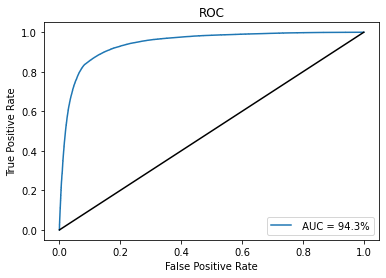

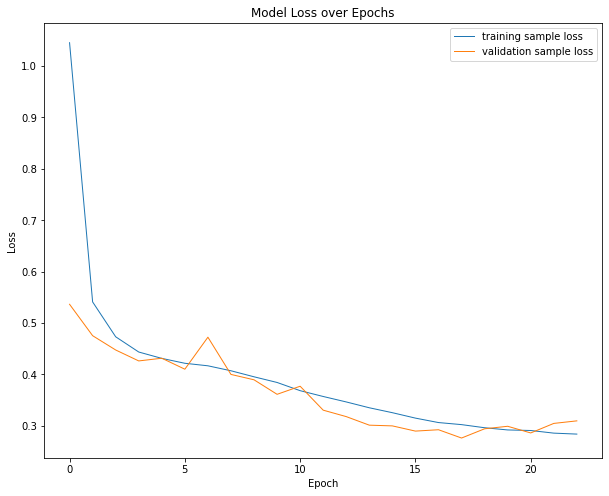

AttributeError: 'int' object has no attribute 'astype'

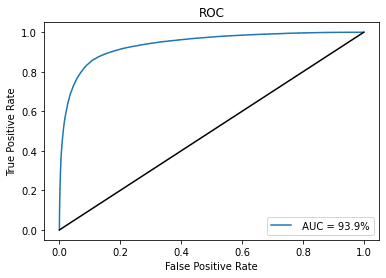

In [26]:
for i in sb_ratio:
    if(i == 1.0):
        signal = 50000
        bg = 50000
    else:
        signal = (np.round(i * 100000))
        bg = (np.round((1 - i) * 100000))

    for j in range(5):
        train_sb(signal.astype(int),bg.astype(int),j,i)
        

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.8762 - tp: 28728.0000 - fp: 14171.0000 - tn: 25942.0000 - fn: 11159.0000 - accuracy: 0.6834 - precision: 0.6697 - recall: 0.7202 - auc: 0.7121 - val_loss: 0.5157 - val_tp: 8428.0000 - val_fp: 2619.0000 - val_tn: 7268.0000 - val_fn: 1685.0000 - val_accuracy: 0.7848 - val_precision: 0.7629 - val_recall: 0.8334 - val_auc: 0.8344
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5199 - tp: 31973.0000 - fp: 9813.0000 - tn: 30300.0000 - fn: 7914.0000 - accuracy: 0.7784 - precision: 0.7652 - recall: 0.8016 - auc: 0.8254 - val_loss: 0.4997 - val_tp: 8079.0000 - val_fp: 1699.0000 - val_tn: 8188.0000 - val_fn: 2034.0000 - val_accuracy: 0.8134 - val_precision: 0.8262 - val_recall: 0.7989 - val_auc: 0.8517
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4828 - tp: 32685.0000 - fp: 8553.0000 - tn: 315

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2838 - tp: 34612.0000 - fp: 3873.0000 - tn: 36240.0000 - fn: 5275.0000 - accuracy: 0.8856 - precision: 0.8994 - recall: 0.8678 - auc: 0.9496 - val_loss: 0.2929 - val_tp: 8659.0000 - val_fp: 1055.0000 - val_tn: 8832.0000 - val_fn: 1454.0000 - val_accuracy: 0.8745 - val_precision: 0.8914 - val_recall: 0.8562 - val_auc: 0.9494
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2827 - tp: 34738.0000 - fp: 3951.0000 - tn: 36162.0000 - fn: 5149.0000 - accuracy: 0.8863 - precision: 0.8979 - recall: 0.8709 - auc: 0.9500 - val_loss: 0.2945 - val_tp: 8814.0000 - val_fp: 1117.0000 - val_tn: 8770.0000 - val_fn: 1299.0000 - val_accuracy: 0.8792 - val_precision: 0.8875 - val_recall: 0.8716 - val_auc: 0.9478
Epoch 23/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2784 - tp: 34812.0000 - fp: 3855.0000 - tn: 36258.0000 - fn: 5075.0000 - accuracy: 0.8884 - prec

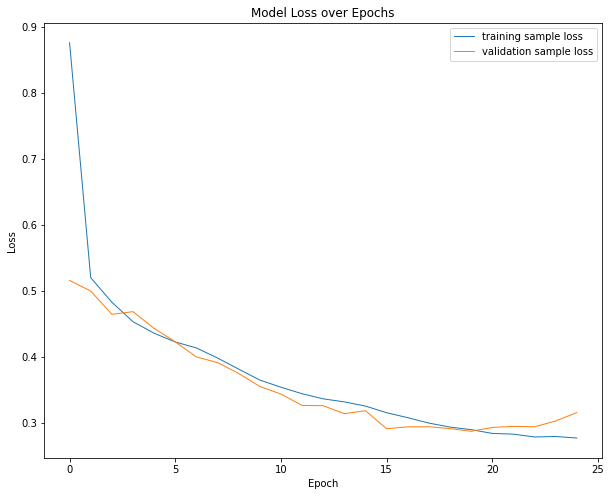

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 58us/sample - loss: 0.8492 - tp: 29524.0000 - fp: 14602.0000 - tn: 25511.0000 - fn: 10363.0000 - accuracy: 0.6879 - precision: 0.6691 - recall: 0.7402 - auc: 0.7178 - val_loss: 0.5129 - val_tp: 8630.0000 - val_fp: 2726.0000 - val_tn: 7161.0000 - val_fn: 1483.0000 - val_accuracy: 0.7896 - val_precision: 0.7600 - val_recall: 0.8534 - val_auc: 0.8528
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5268 - tp: 32428.0000 - fp: 10461.0000 - tn: 29652.0000 - fn: 7459.0000 - accuracy: 0.7760 - precision: 0.7561 - recall: 0.8130 - auc: 0.8233 - val_loss: 0.4512 - val_tp: 8480.0000 - val_fp: 1675.0000 - val_tn: 8212.0000 - val_fn: 1633.0000 - val_accuracy: 0.8346 - val_precision: 0.8351 - val_recall: 0.8385 - val_auc: 0.8758
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4675 - tp: 32731.0000 - fp: 7931.0000 - tn: 32

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2908 - tp: 34574.0000 - fp: 4081.0000 - tn: 36032.0000 - fn: 5313.0000 - accuracy: 0.8826 - precision: 0.8944 - recall: 0.8668 - auc: 0.9472 - val_loss: 0.3139 - val_tp: 8996.0000 - val_fp: 1317.0000 - val_tn: 8570.0000 - val_fn: 1117.0000 - val_accuracy: 0.8783 - val_precision: 0.8723 - val_recall: 0.8895 - val_auc: 0.9433
Epoch 22/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2831 - tp: 34675.0000 - fp: 3966.0000 - tn: 36147.0000 - fn: 5212.0000 - accuracy: 0.8853 - precision: 0.8974 - recall: 0.8693 - auc: 0.9500 - val_loss: 0.3018 - val_tp: 8906.0000 - val_fp: 1299.0000 - val_tn: 8588.0000 - val_fn: 1207.0000 - val_accuracy: 0.8747 - val_precision: 0.8727 - val_recall: 0.8806 - val_auc: 0.9466
Epoch 00022: early stopping


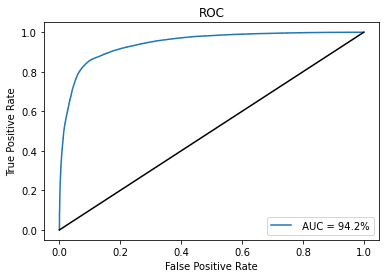

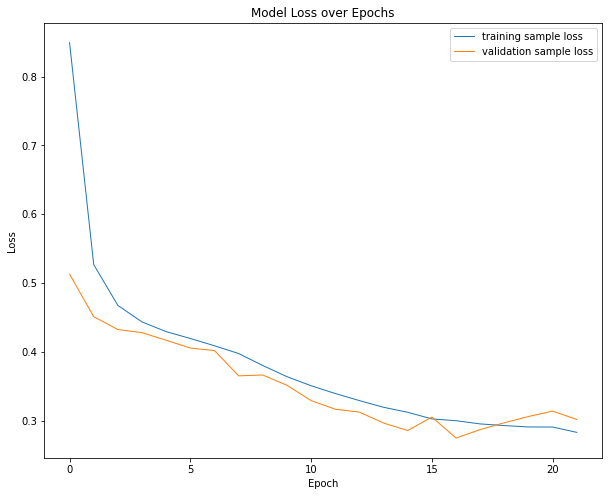

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 67us/sample - loss: 0.8517 - tp: 29387.0000 - fp: 14196.0000 - tn: 25917.0000 - fn: 10500.0000 - accuracy: 0.6913 - precision: 0.6743 - recall: 0.7368 - auc: 0.7215 - val_loss: 0.5046 - val_tp: 8502.0000 - val_fp: 2479.0000 - val_tn: 7408.0000 - val_fn: 1611.0000 - val_accuracy: 0.7955 - val_precision: 0.7742 - val_recall: 0.8407 - val_auc: 0.8442
Epoch 2/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.5176 - tp: 32609.0000 - fp: 10051.0000 - tn: 30062.0000 - fn: 7278.0000 - accuracy: 0.7834 - precision: 0.7644 - recall: 0.8175 - auc: 0.8305 - val_loss: 0.4670 - val_tp: 8409.0000 - val_fp: 1881.0000 - val_tn: 8006.0000 - val_fn: 1704.0000 - val_accuracy: 0.8207 - val_precision: 0.8172 - val_recall: 0.8315 - val_auc: 0.8679
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4765 - tp: 32894.0000 - fp: 8480.0000 - tn: 31

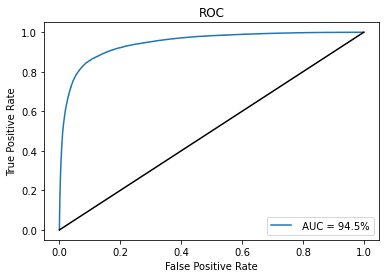

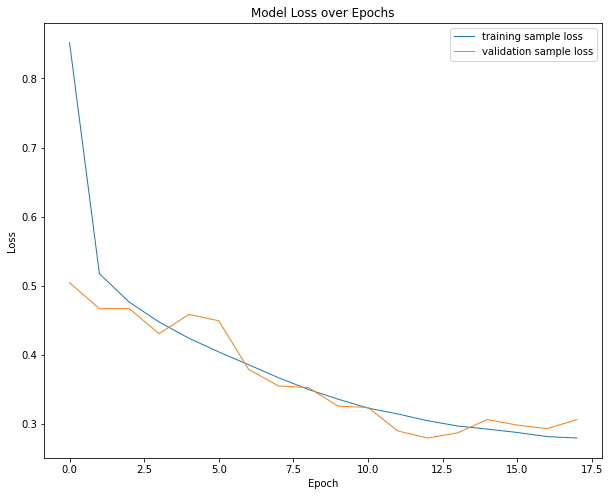

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 60us/sample - loss: 0.8519 - tp: 29580.0000 - fp: 15175.0000 - tn: 24938.0000 - fn: 10307.0000 - accuracy: 0.6815 - precision: 0.6609 - recall: 0.7416 - auc: 0.7120 - val_loss: 0.5266 - val_tp: 8869.0000 - val_fp: 2953.0000 - val_tn: 6934.0000 - val_fn: 1244.0000 - val_accuracy: 0.7901 - val_precision: 0.7502 - val_recall: 0.8770 - val_auc: 0.8456
Epoch 2/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.5409 - tp: 32792.0000 - fp: 11227.0000 - tn: 28886.0000 - fn: 7095.0000 - accuracy: 0.7710 - precision: 0.7450 - recall: 0.8221 - auc: 0.8154 - val_loss: 0.4792 - val_tp: 8520.0000 - val_fp: 1952.0000 - val_tn: 7935.0000 - val_fn: 1593.0000 - val_accuracy: 0.8227 - val_precision: 0.8136 - val_recall: 0.8425 - val_auc: 0.8627
Epoch 3/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.4938 - tp: 32733.0000 - fp: 8957.0000 - tn: 31

Epoch 21/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2896 - tp: 34642.0000 - fp: 4169.0000 - tn: 35944.0000 - fn: 5245.0000 - accuracy: 0.8823 - precision: 0.8926 - recall: 0.8685 - auc: 0.9478 - val_loss: 0.2951 - val_tp: 9103.0000 - val_fp: 1356.0000 - val_tn: 8531.0000 - val_fn: 1010.0000 - val_accuracy: 0.8817 - val_precision: 0.8704 - val_recall: 0.9001 - val_auc: 0.9507
Epoch 22/25
80000/80000 [==============================] - 3s 35us/sample - loss: 0.2841 - tp: 34841.0000 - fp: 4215.0000 - tn: 35898.0000 - fn: 5046.0000 - accuracy: 0.8842 - precision: 0.8921 - recall: 0.8735 - auc: 0.9498 - val_loss: 0.2888 - val_tp: 8910.0000 - val_fp: 1191.0000 - val_tn: 8696.0000 - val_fn: 1203.0000 - val_accuracy: 0.8803 - val_precision: 0.8821 - val_recall: 0.8810 - val_auc: 0.9501
Epoch 23/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.2822 - tp: 34838.0000 - fp: 4025.0000 - tn: 36088.0000 - fn: 5049.0000 - accuracy: 0.8866 - prec

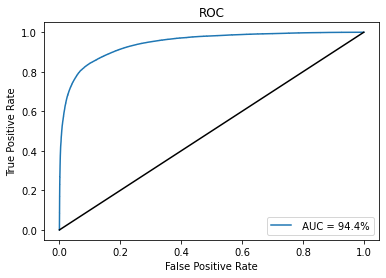

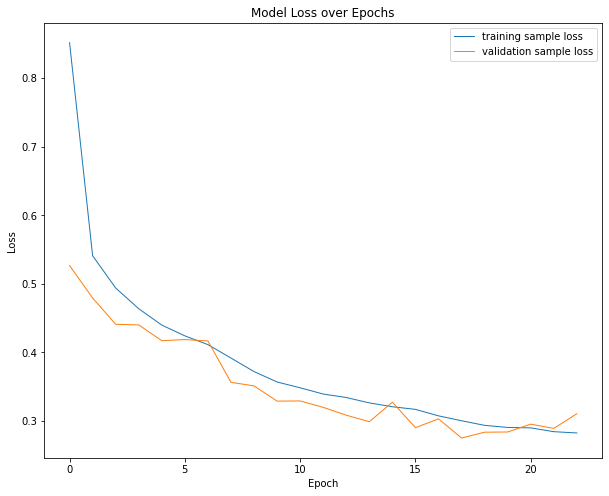

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 5s 59us/sample - loss: 0.7417 - tp: 31060.0000 - fp: 15338.0000 - tn: 24775.0000 - fn: 8827.0000 - accuracy: 0.6979 - precision: 0.6694 - recall: 0.7787 - auc: 0.7377 - val_loss: 0.5057 - val_tp: 8714.0000 - val_fp: 2720.0000 - val_tn: 7167.0000 - val_fn: 1399.0000 - val_accuracy: 0.7940 - val_precision: 0.7621 - val_recall: 0.8617 - val_auc: 0.8552
Epoch 2/25
80000/80000 [==============================] - 3s 38us/sample - loss: 0.5108 - tp: 33009.0000 - fp: 10268.0000 - tn: 29845.0000 - fn: 6878.0000 - accuracy: 0.7857 - precision: 0.7627 - recall: 0.8276 - auc: 0.8364 - val_loss: 0.4657 - val_tp: 7924.0000 - val_fp: 1375.0000 - val_tn: 8512.0000 - val_fn: 2189.0000 - val_accuracy: 0.8218 - val_precision: 0.8521 - val_recall: 0.7835 - val_auc: 0.8702
Epoch 3/25
80000/80000 [==============================] - 3s 36us/sample - loss: 0.4631 - tp: 32780.0000 - fp: 7860.0000 - tn: 322

Epoch 21/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2832 - tp: 34794.0000 - fp: 4044.0000 - tn: 36069.0000 - fn: 5093.0000 - accuracy: 0.8858 - precision: 0.8959 - recall: 0.8723 - auc: 0.9499 - val_loss: 0.2938 - val_tp: 8904.0000 - val_fp: 1088.0000 - val_tn: 8799.0000 - val_fn: 1209.0000 - val_accuracy: 0.8852 - val_precision: 0.8911 - val_recall: 0.8805 - val_auc: 0.9508
Epoch 22/25
80000/80000 [==============================] - 3s 37us/sample - loss: 0.2788 - tp: 34793.0000 - fp: 3850.0000 - tn: 36263.0000 - fn: 5094.0000 - accuracy: 0.8882 - precision: 0.9004 - recall: 0.8723 - auc: 0.9513 - val_loss: 0.3079 - val_tp: 8396.0000 - val_fp: 905.0000 - val_tn: 8982.0000 - val_fn: 1717.0000 - val_accuracy: 0.8689 - val_precision: 0.9027 - val_recall: 0.8302 - val_auc: 0.9442
Epoch 00022: early stopping


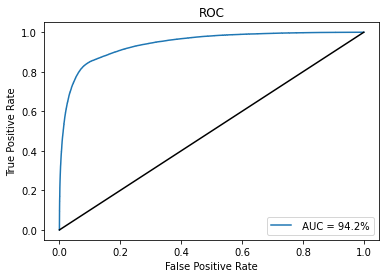

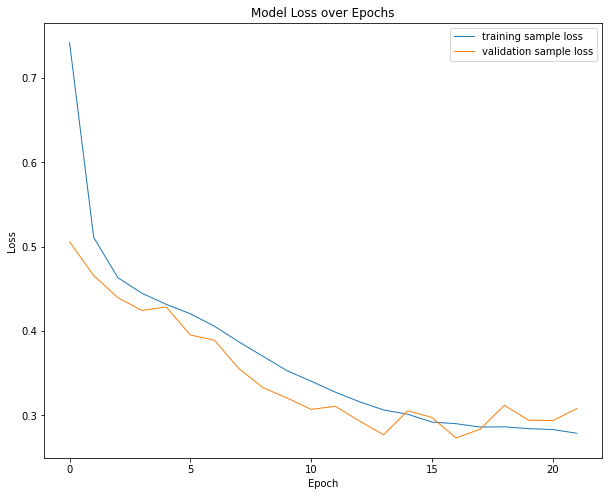

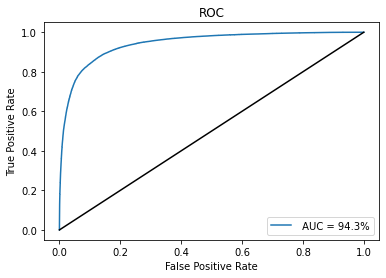

In [27]:
for j in range(5):
  train_sb(50000,50000,j,1.0)

In [130]:
def train_optimal():
    auc_list = []
    tpr_list = []
    fpr_list = []


    x_train,x_val,y_train,y_val = train_test_split(np_combined_SR_labeled[:,[2,6,7,8]],np_combined_SR_labeled[:,-1], test_size = 0.2, random_state=4) #sb label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1]
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=50, batch_size=512,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)

    y_pred = classifier.predict(x_test) 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list.append(auc_value)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')
    print(auc_value)
    print(auc_list)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    #np.save('../Results/Classifier/optimal/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_sb),allow_pickle = True)
    #np.save('../Results/Classifier/optimal/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_sb),allow_pickle = True)
    #np.save('../Results/Classifier/optimal/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_sb),allow_pickle = True)

Train on 157308 samples, validate on 39328 samples
Epoch 1/50
157308/157308 [==============================] - 3s 19us/sample - loss: 1.1543 - tp: 36786.0000 - fp: 29812.0000 - tn: 67079.0000 - fn: 23631.0000 - accuracy: 0.6603 - precision: 0.5524 - recall: 0.6089 - auc: 0.6684 - val_loss: 0.5518 - val_tp: 13210.0000 - val_fp: 7797.0000 - val_tn: 16446.0000 - val_fn: 1875.0000 - val_accuracy: 0.7541 - val_precision: 0.6288 - val_recall: 0.8757 - val_auc: 0.8364
Epoch 2/50
157308/157308 [==============================] - 1s 7us/sample - loss: 0.5630 - tp: 43211.0000 - fp: 22477.0000 - tn: 74414.0000 - fn: 17206.0000 - accuracy: 0.7477 - precision: 0.6578 - recall: 0.7152 - auc: 0.7887 - val_loss: 0.4804 - val_tp: 12267.0000 - val_fp: 3940.0000 - val_tn: 20303.0000 - val_fn: 2818.0000 - val_accuracy: 0.8282 - val_precision: 0.7569 - val_recall: 0.8132 - val_auc: 0.8542
Epoch 3/50
157308/157308 [==============================] - 1s 7us/sample - loss: 0.4956 - tp: 44456.0000 - fp: 16484.00

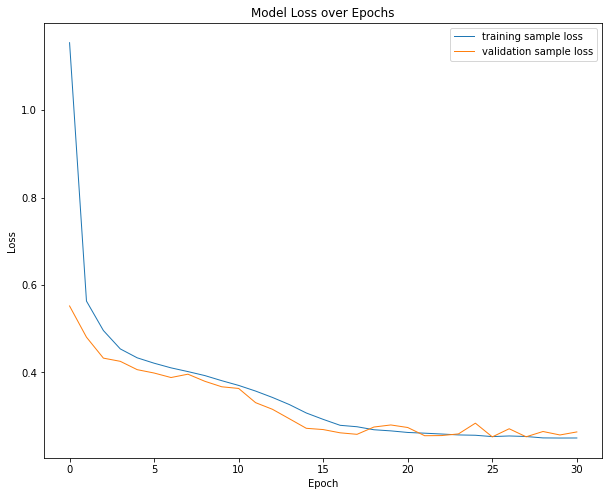

0.9540258370408201
[0.9540258370408201]


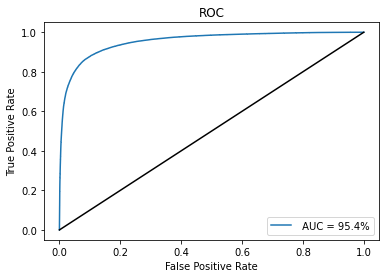

In [131]:
train_optimal()